<a href="https://colab.research.google.com/github/denshanif/lulc_ikn/blob/main/lulc_ikn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instalasi, Impor Library, dan Koneksi Google Drive

In [ ]:
# ============================================================
# 📦 Instalasi library
# ============================================================
!pip install -q rasterio pillow geemap

# ============================================================
# 📚 Import Library
# ============================================================

# Standard Library
import os
import re
import time
import datetime
import pytz
import pickle
import requests
from io import BytesIO

# Google Earth Engine & Geospatial
import ee
import geemap
import rasterio
from rasterio.plot import show

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches

# Data Science & ML
import pandas as pd
import numpy as np
from sklearn.metrics import (
    precision_recall_fscore_support,
    confusion_matrix,
    cohen_kappa_score
)
from scipy.stats import chi2

# Widgets & Display
from ipywidgets import Dropdown, VBox, SelectMultiple
from IPython.display import display, Image as IPyImage
from ipyleaflet import WidgetControl

# Image processing
from PIL import Image

# ============================================================
# 🔗 Google Drive Integration
# ============================================================
from google.colab import drive

drive_path = '/content/drive/MyDrive'
if not os.path.exists(drive_path):
    try:
        drive.mount('/content/drive', force_remount=False)
        print('✅ Drive mounted (New Session).')
    except Exception:
        drive.mount('/content/drive', force_remount=True)
        print('🔄 Drive remounted (Forced).')
else:
    print('📂 Drive already mounted.')


📂 Drive already mounted.


# Fungsi-Fungsi Bantuan (Utility & Data I/O)

In [ ]:
def log_print(message):
    """Custom print function for logging with timestamp in UTC+7."""
    jakarta_tz = pytz.timezone('Asia/Jakarta')
    timestamp = datetime.datetime.now(jakarta_tz).strftime("%Y-%m-%d %H:%M:%S")
    print(f"[{timestamp}] {message}")

def initialize_gee():
    """Inisialisasi Google Earth Engine dengan proyek yang ditentukan."""
    log_print("Menginisialisasi Google Earth Engine")
    try:
        ee.Initialize()
    except Exception as e:
        ee.Authenticate()
        ee.Initialize(project='lulc-ikn')
    log_print("Google Earth Engine berhasil diinisialisasi")

def initialize_map():
    """Inisialisasi peta dan menambahkan layer area IKN."""
    log_print("Menginisialisasi peta")
    Map = geemap.Map()
    kawasan_ikn = ee.FeatureCollection('projects/lulc-ikn/assets/Kawasan_IKN')
    Map.addLayer(kawasan_ikn, {"color": "blue"}, 'kawasan_inti_ikn', True, 0.3)
    log_print("Peta diinisialisasi dengan area IKN")
    return Map, kawasan_ikn

def get_satellite_image(start_date, end_date, kawasan_ikn):
    """Mengambil koleksi citra satelit Sentinel-2."""
    log_print(f"Mengambil citra Sentinel-2 dari {start_date} sampai {end_date}")
    s2 = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED").filterDate(start_date, end_date)
    s2_filter = s2.filterBounds(kawasan_ikn)
    log_print(f"Total citra satelit yang ditemukan: {s2_filter.size().getInfo()}")
    return s2_filter

def export_geotiffs_to_drive(image_collection, kawasan_ikn, resolution=30, gee_export_folder='temp_geotiff'):
    """Mengekspor koleksi citra GEE sebagai GeoTIFF ke Google Drive."""
    log_print(f"Memulai proses ekspor GeoTIFF ke Google Drive folder '{gee_export_folder}'.")

    image_count = image_collection.size().getInfo()
    image_list = image_collection.toList(image_count)
    tasks = {}

    log_print(f"Total citra yang akan diekspor sebagai GeoTIFF: {image_count}")
    if image_count == 0:
        log_print("Tidak ada citra untuk diekspor sebagai GeoTIFF.")
        return {'completed_exports': {}, 'failed_exports': []}

    for i in range(image_count):
        image = ee.Image(image_list.get(i))
        date_str = image.date().format('YYYY-MM-dd_HH:mm:ss').getInfo()

        export_description = f's2_ikn_{date_str}'

        export_params = {
            'image': image.visualize(**{
                'bands': ['B4', 'B3', 'B2'],
                'min': 0,
                'max': 3000,
                'gamma': 1.4
            }),
            'description': export_description,
            'folder': gee_export_folder,
            'scale': resolution,
            'region': kawasan_ikn.geometry(),
            'maxPixels': 1e13,
            'fileFormat': 'GeoTIFF'
        }

        try:
            task = ee.batch.Export.image.toDrive(**export_params)
            task.start()
            tasks[date_str] = task
            log_print(f"Memulai ekspor GEE untuk GeoTIFF: {export_description} (Task ID: {task.id})")
        except Exception as e:
            log_print(f"Gagal memulai ekspor GEE untuk {export_description}: {str(e)}")

    completed_exports = {}
    failed_exports = []

    active_tasks_monitoring = {k: v for k, v in tasks.items() if v is not None}

    while active_tasks_monitoring:
        log_print(f"Memantau {len(active_tasks_monitoring)} tugas ekspor GEE yang aktif...")
        time.sleep(30)
        for date_str in list(active_tasks_monitoring.keys()):
            task_obj = active_tasks_monitoring[date_str]
            try:
                status_info = task_obj.status()
                state = status_info['state']

                if state == ee.batch.Task.State.COMPLETED:
                    completed_exports[date_str] = status_info
                    log_print(f"Ekspor GeoTIFF GEE selesai: {tasks[date_str].config.get('description')}")
                    del active_tasks_monitoring[date_str]
                elif state in [ee.batch.Task.State.FAILED, ee.batch.Task.State.CANCELLED]:
                    failed_exports.append((date_str, status_info))
                    log_print(f"Ekspor GeoTIFF GEE gagal/dibatalkan: {tasks[date_str].config.get('description')} - {state} - Pesan: {status_info.get('error_message', 'N/A')}")
                    del active_tasks_monitoring[date_str]
                elif state == ee.batch.Task.State.UNSUBMITTED:
                    log_print(f"Tugas untuk {tasks[date_str].config.get('description')} status UNSUBMITTED. Mencoba memulai lagi.")
                    task_obj.start()
            except Exception as e:
                log_print(f"Error saat memeriksa status GEE untuk {tasks[date_str].config.get('description')} (Task ID: {task_obj.id}): {str(e)}")
                failed_exports.append((date_str, {'state': 'ERROR_CHECKING_STATUS', 'description': tasks[date_str].config.get('description'), 'error_message': str(e)}))
                del active_tasks_monitoring[date_str]

    log_print("Pemantauan semua tugas ekspor GeoTIFF GEE selesai.")
    return {'completed_exports': completed_exports, 'failed_exports': failed_exports}

def convert_geotiffs_to_jpgs(source_geotiff_drive_folder, output_jpg_drive_folder, delete_source_geotiff=True):
    """Mengkonversi GeoTIFF dari Drive ke JPG dan menyimpannya kembali ke Drive."""
    log_print(f"Mulai konversi GeoTIFF dari '{source_geotiff_drive_folder}' ke '{output_jpg_drive_folder}'.")
    base_drive_path = '/content/drive/MyDrive/'
    source_folder_full_path = os.path.join(base_drive_path, source_geotiff_drive_folder)
    output_folder_full_path = os.path.join(base_drive_path, output_jpg_drive_folder)
    os.makedirs(output_folder_full_path, exist_ok=True)
    if not os.path.isdir(source_folder_full_path):
        log_print(f"Folder sumber GeoTIFF tidak ditemukan: {source_folder_full_path}")
        return
    geotiff_files = [f for f in os.listdir(source_folder_full_path) if f.lower().endswith('.tif')]
    log_print(f"Ditemukan {len(geotiff_files)} file GeoTIFF untuk dikonversi.")
    for tif_filename in geotiff_files:
        tif_path = os.path.join(source_folder_full_path, tif_filename)
        jpg_filename = os.path.splitext(tif_filename)[0] + '.jpg'
        jpg_path = os.path.join(output_folder_full_path, jpg_filename)
        try:
            with rasterio.open(tif_path) as src:
                img_array = src.read((1, 2, 3))
                img_array_rgb_transposed = np.moveaxis(img_array, 0, -1)
                img = Image.fromarray(img_array_rgb_transposed.astype(np.uint8))
                img.save(jpg_path, quality=95)
            log_print(f"Berhasil konversi '{tif_filename}' ke '{jpg_filename}'.")
            if delete_source_geotiff:
                os.remove(tif_path)
                log_print(f"Menghapus GeoTIFF sumber: {tif_path}")
        except Exception as e:
            log_print(f"Gagal konversi '{tif_filename}': {str(e)}")

# Fungsi-Fungsi Inti (Pra-pemrosesan & Machine Learning)

In [ ]:
def qa_band_s2(image):
    """Masking awan dan cirrus dari band QA60 Sentinel-2."""
    qa = image.select('QA60')
    cloud_bit_mask = 1 << 10
    cirrus_bit_mask = 1 << 11
    mask = qa.bitwiseAnd(cloud_bit_mask).eq(0).And(qa.bitwiseAnd(cirrus_bit_mask).eq(0))
    return image.updateMask(mask)

def apply_cloud_mask(s2, kawasan_ikn):
    """Menerapkan cloud masking dan komposit median."""
    log_print("Menerapkan masking awan dan membuat komposit median")
    s2_cloud_mask = s2.filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 50)).map(qa_band_s2)
    return s2_cloud_mask.median().clip(kawasan_ikn)

def calculate_indices(image):
    """Menghitung indeks NDVI, NDBI, dan NDWI untuk citra."""
    log_print("Menghitung indeks spektral (NDVI, NDBI, NDWI)")

    def compute_indices(img):
        ndvi = img.normalizedDifference(['B8', 'B4']).rename('NDVI')
        ndbi = img.normalizedDifference(['B11', 'B8']).rename('NDBI')
        ndwi = img.normalizedDifference(['B3', 'B8']).rename('NDWI')
        return img.addBands([ndvi, ndbi, ndwi])

    if isinstance(image, ee.Image):
        return compute_indices(image)
    elif isinstance(image, ee.ImageCollection):
        return image.map(compute_indices)
    else:
        raise TypeError("Input harus berupa ee.Image atau ee.ImageCollection")

def split_data(image, sample_data, bands_to_use, landcover_labels, split_ratio=0.7, seed=42):
    """
    Membagi data sampel menjadi set pelatihan dan validasi
    """
    log_print(f"Memulai pembagian data (Rasio: {split_ratio}, Seed: {seed})")

    # Mengambil sample dengan properti bands yang dipilih
    sample = image.select(bands_to_use).sampleRegions(
        collection=sample_data,
        properties=[landcover_labels],
        scale=30
    )

    # Menghitung jumlah sampel per kelas
    class_counts = sample.aggregate_histogram(landcover_labels).getInfo()

    training_features = []
    validation_features = []

    # Melakukan stratified sampling untuk setiap kelas
    for class_value in class_counts.keys():
        class_features = sample.filter(
            ee.Filter.eq(landcover_labels, int(class_value)))
        class_size = class_features.size().getInfo()

        # Menghitung jumlah sampel untuk training
        n_training = int(class_size * split_ratio)

        # Mengacak feature dalam kelas dengan seed yang konsisten
        shuffled_features = class_features.randomColumn('random', seed)

        # Membagi data untuk kelas ini
        class_training = shuffled_features.limit(n_training, 'random')
        class_validation = shuffled_features.filter(
            ee.Filter.gt('random', class_training.aggregate_max('random'))
        )

        training_features.append(class_training)
        validation_features.append(class_validation)

    # Menggabungkan semua feature
    if training_features:
        training_sample = ee.FeatureCollection(training_features).flatten()
    else:
        training_sample = ee.FeatureCollection([])

    if validation_features:
        validation_sample = ee.FeatureCollection(validation_features).flatten()
    else:
        validation_sample = ee.FeatureCollection([])

    train_size = training_sample.size().getInfo()
    val_size = validation_sample.size().getInfo()

    log_print(f"Data dibagi: {train_size} sampel training, {val_size} sampel validasi.")

    if train_size == 0 or val_size == 0:
        log_print("Sampel training atau validasi kosong setelah dibagi! Proses ini mungkin tidak berjalan dengan baik.")
        return None, None

    train_dist = training_sample.aggregate_histogram(landcover_labels).getInfo()
    val_dist = validation_sample.aggregate_histogram(landcover_labels).getInfo()
    log_print(f"Distribusi kelas training: {train_dist}")
    log_print(f"Distribusi kelas validasi: {val_dist}")

    return training_sample, validation_sample

def train_and_classify(scenarios, training_sample, landcover_labels, bands_to_use, image):
    """Melatih model dan melakukan klasifikasi untuk setiap skenario."""
    trained_models = {}
    classified_images = {}

    if training_sample.size().getInfo() == 0:
        log_print("Tidak ada sampel pelatihan yang tersedia. Melewatkan pelatihan dan klasifikasi.")
        return {}, {}

    for name, classifier in scenarios:
        log_print(f'Melatih {name}...')
        try:
            trained_classifier = classifier.train(training_sample, landcover_labels, bands_to_use)
            trained_models[name] = trained_classifier

            classified_images[name] = image.select(bands_to_use).classify(trained_classifier)

            log_print(f'Pelatihan {name} selesai')
        except Exception as e:
            log_print(f"Gagal melatih atau mengklasifikasi untuk {name}: {str(e)}")
            continue

    return trained_models, classified_images

def validate_model(trained_classifier, validation_sample, landcover_labels, name, classified_image):
    """Memvalidasi model yang telah dilatih dan menghitung metrik kinerja."""
    log_print(f'Memvalidasi model: {name}')

    if validation_sample.size().getInfo() == 0:
        log_print(f"Tidak ada sampel validasi untuk model {name}. Melewatkan validasi.")
        return None

    try:
        start_time = time.time()

        validated = validation_sample.classify(trained_classifier)
        test_accuracy = validated.errorMatrix(landcover_labels, 'classification')

        overall_accuracy = test_accuracy.accuracy().getInfo()
        kappa = test_accuracy.kappa().getInfo()

        true_labels = validated.aggregate_array(landcover_labels).getInfo()
        predicted_labels = validated.aggregate_array('classification').getInfo()

        if not true_labels or not predicted_labels:
            log_print(f"Tidak dapat mengambil labels untuk {name}")
            return None

        from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

        precision, recall, f1, _ = precision_recall_fscore_support(
            true_labels, predicted_labels, average='weighted', zero_division=0)
        conf_matrix = confusion_matrix(true_labels, predicted_labels).tolist()

        total_computation_time = time.time() - start_time

        log_print(f'Validasi selesai untuk {name}. Akurasi: {overall_accuracy:.4f}, Waktu: {total_computation_time:.2f} detik')

        return {
            'name': name,
            'algorithm': name.split('_')[0],
            'validation_accuracy': overall_accuracy,
            'kappa': kappa,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'conf_matrix': conf_matrix,
            'classified_image': classified_image,
            'computation_time': total_computation_time
        }

    except Exception as e:
        log_print(f"Error dalam validasi model {name}: {str(e)}")
        return None

# Fungsi-Fungsi untuk Visualisasi dan Pelaporan

In [ ]:
# Set style global untuk semua plot
plt.rcParams.update({
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',
    'savefig.facecolor': 'white',
    'font.size': 12,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 11,
    'figure.titlesize': 18,
    'font.family': 'DejaVu Sans'
})

def get_model_colors():
    """Centralized color mapping with distinct, non-similar colors for all RF and SVM scenarios."""

    rf_colors = [
        '#1f77b4',  # Blue
        '#ff7f0e',  # Orange
        '#2ca02c',  # Green
        '#d62728',  # Red
        '#9467bd',  # Purple
        '#8c564b'   # Brown
    ]

    svm_colors = [
        '#e41a1c',  # Merah
        '#377eb8',  # Biru
        '#4daf4a',  # Hijau
        '#984ea3',  # Ungu
        '#ff7f00',  # Oranye
        '#a65628'   # Coklat
    ]

    return {
        'RF_1tree': rf_colors[0],
        'RF_10trees': rf_colors[1],
        'RF_50trees': rf_colors[2],
        'RF_100trees': rf_colors[3],
        'RF_200trees': rf_colors[4],
        'RF_500trees': rf_colors[5],

        'SVM_LINEAR': svm_colors[0],
        'SVM_LINEAR_cost10': svm_colors[1],
        'SVM_LINEAR_cost100': svm_colors[2],

        'SVM_POLY': svm_colors[3],
        'SVM_POLY_degree5': svm_colors[4],
        'SVM_POLY_gamma1': svm_colors[5],
    }

def get_model_color(name, model_colors=None):
    """Get color for a specific model (exact match)."""
    if model_colors is None:
        model_colors = get_model_colors()

    return model_colors.get(name, '#000000')

def display_metrics_table(df):
    """Menampilkan tabel metrik performa umum (Akurasi, Kappa, dll)."""
    log_print("Membuat tabel metrik performa model...")

    # Create display dataframe
    df_display = df[['name', 'validation_accuracy', 'kappa', 'precision', 'recall', 'f1_score']].copy()
    df_display.columns = ['Skenario', 'Akurasi (%)', 'Kappa', 'Presisi (%)', 'Recall (%)', 'F1-Skor (%)']

    # Format percentage columns
    for col in ['Akurasi (%)', 'Presisi (%)', 'Recall (%)', 'F1-Skor (%)']:
        df_display[col] = df_display[col].apply(lambda x: f"{x*100:.2f}")
    df_display['Kappa'] = df_display['Kappa'].apply(lambda x: f"{x:.4f}")

    for algo, algo_name in [('RF', 'Random Forest'), ('SVM', 'Support Vector Machine')]:
        df_algo = df_display[df_display['Skenario'].str.startswith(algo)].copy()
        if not df_algo.empty:
            df_algo_sorted = df_algo.sort_values('Akurasi (%)', ascending=False)
            print(f"\n{'='*80}")
            print(f"TABEL METRIK PERFORMA: {algo_name.upper()}")
            print(f"{'='*80}")
            display(df_algo_sorted.set_index('Skenario'))

            print(f"\nRingkasan {algo_name}:")
            accuracy_vals = [float(x) for x in df_algo['Akurasi (%)'].values]
            print(f"  - Akurasi Rata-rata: {np.mean(accuracy_vals):.2f}%")
            print(f"  - Akurasi Tertinggi: {np.max(accuracy_vals):.2f}%")
            print(f"  - Akurasi Terendah: {np.min(accuracy_vals):.2f}%")
            print(f"  - Standar Deviasi: {np.std(accuracy_vals):.2f}%")

def plot_metrics_comparison_improved(df):
    """Plot perbandingan metrik"""
    log_print("Membuat plot performa per metrik...")

    algo_name = 'Random Forest' if df['name'].iloc[0].startswith('RF') else 'Support Vector Machine'

    metrics = ['validation_accuracy', 'precision', 'recall', 'f1_score']
    metric_labels = ['Validation Accuracy', 'Precision', 'Recall', 'F1-Score']

    df_plot = df.copy()
    model_colors = get_model_colors()

    for m in metrics:
        df_plot[m] = df_plot[m] * 100

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'Diagram Batang Perbandingan Performa Model {algo_name}',
                fontsize=18, fontweight='bold', y=0.995)

    for idx, (metric, label) in enumerate(zip(metrics, metric_labels)):
        row = idx // 2
        col = idx % 2
        ax = axes[row, col]

        df_sorted = df_plot.sort_values(metric, ascending=False)

        bars = ax.bar(range(len(df_sorted)), df_sorted[metric],
                     color=[get_model_color(name, model_colors) for name in df_sorted['name']],
                     alpha=0.85, edgecolor='black', linewidth=1.2)

        # Customize x-axis
        ax.set_xticks(range(len(df_sorted)))
        ax.set_xticklabels(df_sorted['name'], rotation=45, ha='right', fontsize=10)

        # Value labels on bars
        for i, (bar, value) in enumerate(zip(bars, df_sorted[metric])):
            ax.text(i, value + 0.3, f'{value:.1f}%',
                   ha='center', va='bottom', fontsize=9, fontweight='bold')

        # KUNCI: Adjusted Y-axis untuk memperjelas perbedaan
        min_val = df_sorted[metric].min()
        max_val = df_sorted[metric].max()
        margin = (max_val - min_val) * 0.3  # 30% margin
        ax.set_ylim(min_val - margin, max_val + margin)

        # Tambahkan garis rata-rata
        mean_val = df_sorted[metric].mean()
        ax.axhline(y=mean_val, color='red', linestyle='--',
                  linewidth=2, alpha=0.5, label=f'Rata-rata: {mean_val:.1f}%')

        ax.set_ylabel('Persentase (%)', fontsize=11, fontweight='bold')
        ax.set_title(label, fontsize=13, fontweight='bold', pad=10)
        ax.grid(True, axis='y', alpha=0.3, linestyle='--')
        ax.legend(loc='lower right', fontsize=9)

    plt.tight_layout()
    plt.show()

def calculate_area_for_all_classes(classified_image, kawasan_ikn, pixel_area_km2):
    """Menghitung luas setiap kelas tutupan lahan."""
    log_print("Menghitung luas untuk semua kelas tutupan lahan")
    area_per_class = pixel_area_km2.addBands(classified_image).reduceRegion(
        reducer=ee.Reducer.sum().group(groupField=1),
        geometry=kawasan_ikn.geometry(),
        scale=10,
        maxPixels=1e13
    ).get('groups').getInfo()

    area_by_class = {int(item['group']): item['sum']
                     for item in area_per_class}
    log_print(
        f"Perhitungan luas selesai. Kelas yang ditemukan: {list(area_by_class.keys())}")
    return area_by_class

def update_legend_with_area_percentage(classified_image, kawasan_ikn, label_descriptions, palette, pixel_area_km2):
    """Memperbarui legenda peta dengan informasi luas dan persentase untuk setiap kelas tutupan lahan."""
    log_print("Memperbarui legenda dengan persentase luas")
    total_area_ikn_km2 = pixel_area_km2.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=kawasan_ikn.geometry(),
        scale=10,
        maxPixels=1e13
    ).get('area').getInfo()

    area_by_class = calculate_area_for_all_classes(
        classified_image, kawasan_ikn, pixel_area_km2)

    legend_items_classification = {}
    for label_value, description in label_descriptions.items():
        area_km2 = area_by_class.get(label_value, 0)
        percentage = (area_km2 / total_area_ikn_km2) * \
            100 if area_km2 > 0 else 0

        legend_items_classification[f'{description}: {area_km2:.2f} km² ({percentage:.2f}%)'] = palette[
            label_value - 1]

    log_print("Legenda diperbarui dengan persentase luas")
    return legend_items_classification

def visualize_map(map_object, kawasan_ikn, s2_ikn_with_indices, validation_results,
                  vis_classified, label_descriptions, pixel_area_km2):
    """Menampilkan peta dengan Sentinel, indeks, dan kontrol interaktif untuk 12 skenario klasifikasi.
    """
    try:
        # Reset Map
        map_object, _ = initialize_map()

        # Visualisasi dasar Sentinel-2
        vis_params = {
            "bands": ["B4", "B3", "B2"],
            "min": 0,
            "max": 3000,
            "gamma": 1.4
        }

        # Tambahkan layer dasar
        map_object.addLayer(s2_ikn_with_indices, vis_params, "Sentinel-2 IKN")
        map_object.addLayer(s2_ikn_with_indices.select('NDVI'),
                            {'min': -1, 'max': 1, 'palette': ['white', 'green']}, 'NDVI')
        map_object.addLayer(s2_ikn_with_indices.select('NDBI'),
                            {'min': -1, 'max': 1, 'palette': ['red', 'yellow']}, 'NDBI')
        map_object.addLayer(s2_ikn_with_indices.select('NDWI'),
                            {'min': -1, 'max': 1, 'palette': ['green', 'white', 'blue']}, 'NDWI')

        # Hitung luas sekali di awal
        legend_cache = {}
        for result in validation_results:
            scenario_name = result['name']
            legend_items = update_legend_with_area_percentage(
                result['classified_image'], kawasan_ikn, label_descriptions,
                vis_classified['palette'], pixel_area_km2
            )
            legend_cache[scenario_name] = legend_items

        current_legend = None

        def update_legend(scenario_name):
            nonlocal current_legend
            legend_items = legend_cache[scenario_name]

            if current_legend is not None:
                map_object.remove_legend(current_legend)

            current_legend = map_object.add_legend(
                title=scenario_name, legend_dict=legend_items
            )

        # Dropdown untuk memilih legend
        scenario_selector = Dropdown(
            options=[result['name'] for result in validation_results],
            description='Legend:',
        )

        def on_dropdown_change(change):
            if change['new']:
                update_legend(change['new'])

        scenario_selector.observe(on_dropdown_change, names='value')

        # SelectMultiple untuk toggle layer klasifikasi
        scenario_multi = SelectMultiple(
            options=[result['name'] for result in validation_results],
            description="Show Layers:",
        )

        def toggle_layers(change):
            """Hidup/matikan layer klasifikasi berdasarkan pilihan user"""
            selected = change['new']
            for result in validation_results:
                layer_name = f"{result['name']} Classification"
                if result['name'] in selected:
                    map_object.addLayer(result['classified_image'], vis_classified, layer_name)
                else:
                    try:
                        map_object.remove_layer(layer_name)
                    except Exception:
                        pass

        scenario_multi.observe(toggle_layers, names="value")

        # Tampilkan widget di bawah peta
        display(VBox([scenario_selector, scenario_multi]))

        # Set view map
        map_object.centerObject(kawasan_ikn, 10)
        map_object.addLayerControl()

        # Tampilkan legend default (skenario pertama)
        initial_scenario = validation_results[0]['name']
        scenario_selector.value = initial_scenario
        update_legend(initial_scenario)

        return map_object

    except Exception as e:
        log_print(f"Gagal menampilkan peta: {str(e)}")
        raise

# Fungsi-Fungsi untuk Analisis Confusion Matrix Detail

def calculate_per_class_metrics(conf_matrix, class_names):
    """
    Menghitung metrik per kelas dari confusion matrix.

    Parameters:
    - conf_matrix: numpy array confusion matrix
    - class_names: list nama kelas

    Returns:
    - DataFrame dengan metrik per kelas
    """
    conf_matrix = np.array(conf_matrix)

    # Producer's Accuracy (Recall per kelas)
    producer_acc = np.diag(conf_matrix) / conf_matrix.sum(axis=0)

    # User's Accuracy (Precision per kelas)
    user_acc = np.diag(conf_matrix) / conf_matrix.sum(axis=1)

    # Commission Error (1 - User's Accuracy)
    commission = 1 - user_acc

    # Omission Error (1 - Producer's Accuracy)
    omission = 1 - producer_acc

    # F1-Score per kelas
    f1_per_class = 2 * (producer_acc * user_acc) / (producer_acc + user_acc)
    f1_per_class = np.nan_to_num(f1_per_class)  # Handle division by zero

    # Buat DataFrame
    metrics_df = pd.DataFrame({
        'Kelas': class_names,
        "Producer's Accuracy (%)": producer_acc * 100,
        "User's Accuracy (%)": user_acc * 100,
        'Commission Error (%)': commission * 100,
        'Omission Error (%)': omission * 100,
        'F1-Score (%)': f1_per_class * 100,
        'Jumlah Sampel': conf_matrix.sum(axis=1)
    })

    return metrics_df

def plot_confusion_matrix_heatmap(conf_matrix, class_names, model_name, normalize=False):
    """
    Membuat heatmap confusion matrix.

    Parameters:
    - conf_matrix: numpy array confusion matrix
    - class_names: list nama kelas
    - model_name: nama model untuk judul
    - normalize: jika True, normalisasi per baris (True labels)
    """
    conf_matrix = np.array(conf_matrix)

    if normalize:
        conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
        conf_matrix_norm = np.nan_to_num(conf_matrix_norm)  # Handle division by zero
        data_to_plot = conf_matrix_norm
        fmt = '.2%'
        cmap = 'Blues'
        title_suffix = '(Normalized)'
    else:
        data_to_plot = conf_matrix
        fmt = 'd'
        cmap = 'Blues'
        title_suffix = '(Count)'

    plt.figure(figsize=(10, 8))
    sns.heatmap(data_to_plot, annot=True, fmt=fmt, cmap=cmap,
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Proportion' if normalize else 'Count'},
                linewidths=0.5, linecolor='gray')

    plt.title(f'Confusion Matrix - {model_name} {title_suffix}',
              fontsize=14, fontweight='bold', pad=20)
    plt.ylabel('True Label', fontsize=12, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

def compare_confusion_matrices(results_list, class_names):
    """
    Membandingkan confusion matrix dari beberapa model secara visual.

    Parameters:
    - results_list: list of dicts, setiap dict harus punya 'name' dan 'conf_matrix'
    - class_names: list nama kelas
    """
    n_models = len(results_list)

    if n_models > 4:
        log_print(f"Terlalu banyak model untuk divisualisasikan sekaligus ({n_models}). Menampilkan 4 pertama.")
        results_list = results_list[:4]
        n_models = 4

    fig, axes = plt.subplots(2, 2, figsize=(16, 14))
    fig.suptitle('Perbandingan Confusion Matrix (Normalized)',
                 fontsize=16, fontweight='bold', y=0.995)

    axes = axes.flatten()

    for idx, result in enumerate(results_list):
        conf_matrix = np.array(result['conf_matrix'])
        conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
        conf_matrix_norm = np.nan_to_num(conf_matrix_norm)

        ax = axes[idx]
        sns.heatmap(conf_matrix_norm, annot=True, fmt='.2%', cmap='Blues',
                   xticklabels=class_names, yticklabels=class_names,
                   cbar_kws={'label': 'Proportion'}, ax=ax,
                   linewidths=0.5, linecolor='gray')

        accuracy = result.get('validation_accuracy', 0) * 100
        ax.set_title(f"{result['name']}\nAccuracy: {accuracy:.2f}%",
                    fontsize=12, fontweight='bold')
        ax.set_ylabel('True Label', fontsize=10)
        ax.set_xlabel('Predicted Label', fontsize=10)
        ax.tick_params(axis='x', rotation=45)
        ax.tick_params(axis='y', rotation=0)

    # Hide empty subplots if n_models < 4
    for idx in range(n_models, 4):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

def analyze_classification_errors(conf_matrix, class_names):
    """
    Menganalisis pola kesalahan klasifikasi.

    Parameters:
    - conf_matrix: numpy array confusion matrix
    - class_names: list nama kelas

    Returns:
    - DataFrame dengan analisis kesalahan
    """
    conf_matrix = np.array(conf_matrix)
    n_classes = len(class_names)

    error_analysis = []

    for i in range(n_classes):
        for j in range(n_classes):
            if i != j and conf_matrix[i, j] > 0:
                error_count = conf_matrix[i, j]
                total_true = conf_matrix[i].sum()
                error_rate = (error_count / total_true * 100) if total_true > 0 else 0

                error_analysis.append({
                    'True Class': class_names[i],
                    'Predicted As': class_names[j],
                    'Error Count': int(error_count),
                    'Error Rate (%)': error_rate
                })

    error_df = pd.DataFrame(error_analysis)
    error_df = error_df.sort_values('Error Count', ascending=False)

    return error_df

def plot_per_class_accuracy_comparison(best_rf_result, best_svm_result, class_names):
    """
    Membandingkan akurasi per kelas antara RF dan SVM terbaik.

    Parameters:
    - best_rf_result: dict hasil validasi RF terbaik
    - best_svm_result: dict hasil validasi SVM terbaik
    - class_names: list nama kelas
    """
    # Hitung metrik per kelas untuk kedua model
    rf_metrics = calculate_per_class_metrics(best_rf_result['conf_matrix'], class_names)
    svm_metrics = calculate_per_class_metrics(best_svm_result['conf_matrix'], class_names)

    # Setup plot
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f"Perbandingan Metrik Per Kelas\n{best_rf_result['name']} vs {best_svm_result['name']}",
                 fontsize=16, fontweight='bold', y=0.995)

    metrics_to_plot = [
        ("Producer's Accuracy (%)", "Producer's Accuracy"),
        ("User's Accuracy (%)", "User's Accuracy"),
        ('F1-Score (%)', 'F1-Score'),
        ('Commission Error (%)', 'Commission Error')
    ]

    x = np.arange(len(class_names))
    width = 0.35

    for idx, (metric_col, metric_label) in enumerate(metrics_to_plot):
        ax = axes[idx // 2, idx % 2]

        rf_values = rf_metrics[metric_col].values
        svm_values = svm_metrics[metric_col].values

        bars1 = ax.bar(x - width/2, rf_values, width, label=best_rf_result['name'],
                      color='#2ca02c', alpha=0.8, edgecolor='black', linewidth=1)
        bars2 = ax.bar(x + width/2, svm_values, width, label=best_svm_result['name'],
                      color='#e41a1c', alpha=0.8, edgecolor='black', linewidth=1)

        # Add value labels on bars
        for bars in [bars1, bars2]:
            for bar in bars:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.1f}%',
                       ha='center', va='bottom', fontsize=9)

        ax.set_ylabel('Persentase (%)', fontsize=11, fontweight='bold')
        ax.set_title(metric_label, fontsize=12, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(class_names, rotation=45, ha='right')
        ax.legend(loc='best', fontsize=9)
        ax.grid(True, axis='y', alpha=0.3, linestyle='--')

    plt.tight_layout()
    plt.show()

def plot_computational_time_analysis(df):
    """Plot analisis waktu komputasi."""
    log_print("Membuat analisis waktu komputasi...")

    fig, axes = plt.subplots(1, 2, figsize=(16, 7))  # Ubah jadi 1 baris 2 kolom
    fig.suptitle('Analisis Waktu Komputasi Model (Training + Validation)',
                 fontsize=18, fontweight='bold', y=0.98)

    model_colors = get_model_colors()

    rf_data = df[df['name'].str.startswith('RF')].copy()
    svm_data = df[df['name'].str.startswith('SV')].copy()

    # Plot 1: Computation Time Comparison
    ax1 = axes[0]
    df_sorted = df.sort_values('computation_time', ascending=True)
    colors = [get_model_color(name, model_colors) for name in df_sorted['name']]

    bars = ax1.barh(range(len(df_sorted)), df_sorted['computation_time'],
                    color=colors, alpha=0.8, edgecolor='black', linewidth=1)

    ax1.set_yticks(range(len(df_sorted)))
    ax1.set_yticklabels(df_sorted['name'], fontsize=10)
    ax1.set_xlabel('Waktu Komputasi (detik)', fontsize=12, fontweight='bold')
    ax1.set_title('Perbandingan Waktu Komputasi Total', fontsize=13, fontweight='bold')
    ax1.grid(True, alpha=0.3, axis='x', linestyle='--')

    for i, (bar, value) in enumerate(zip(bars, df_sorted['computation_time'])):
        ax1.text(value + max(df_sorted['computation_time'])*0.02, i,
                f'{value:.2f}s', va='center', fontsize=9, fontweight='bold')

    # Plot 2: Computation Time vs Accuracy
    ax2 = axes[1]

    for _, row in df.iterrows():
        color = get_model_color(row['name'], model_colors)
        marker = 'o' if row['name'].startswith('RF') else 's'
        ax2.scatter(row['computation_time'], row['validation_accuracy']*100,
                   s=150, alpha=0.8, c=color, edgecolors='black',
                   linewidth=1.5, marker=marker)
        ax2.annotate(row['name'],
                    (row['computation_time'], row['validation_accuracy']*100),
                    xytext=(5, 5), textcoords='offset points', fontsize=8)

    ax2.set_xlabel('Waktu Komputasi (detik)', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Akurasi Validasi (%)', fontsize=12, fontweight='bold')
    ax2.set_title('Hubungan Waktu Komputasi vs Akurasi', fontsize=13, fontweight='bold')
    ax2.grid(True, alpha=0.3, linestyle='--')
    ax2.legend(['RF (bulat)', 'SVM (kotak)'], fontsize=10)

    # Add summary statistics
    rf_time_mean = rf_data['computation_time'].mean()
    svm_time_mean = svm_data['computation_time'].mean()

    summary_text = f"""Ringkasan Waktu Komputasi:
RF Rata-rata: {rf_time_mean:.2f}s
SVM Rata-rata: {svm_time_mean:.2f}s
Tercepat: {df['computation_time'].min():.2f}s ({df.loc[df['computation_time'].idxmin(), 'name']})
Terlambat: {df['computation_time'].max():.2f}s ({df.loc[df['computation_time'].idxmax(), 'name']})"""

    ax2.text(0.02, 0.98, summary_text, transform=ax2.transAxes,
             fontsize=9, verticalalignment='top',
             bbox=dict(boxstyle='round,pad=0.5', facecolor='lightyellow', alpha=0.8))

    plt.tight_layout()
    plt.show()

    # Print detailed table
    print("\n" + "="*80)
    print("TABEL DETAIL WAKTU KOMPUTASI")
    print("="*80)
    time_df = df[['name', 'computation_time', 'validation_accuracy']].copy()
    time_df = time_df.sort_values('computation_time', ascending=False)
    time_df['validation_accuracy'] = time_df['validation_accuracy'] * 100
    time_df.columns = ['Model', 'Waktu Komputasi (s)', 'Akurasi (%)']
    display(time_df.round(2))
    print("="*80)

def plot_confusion_matrix_with_metrics(result, label_descriptions, normalize=True):
    """
    Menampilkan confusion matrix dengan ringkasan metrik di samping.

    Args:
        result (dict): hasil validasi skenario dari validate_model().
        label_descriptions (dict): mapping {class_id: class_name}.
        normalize (bool): jika True → tampilkan normalized (%), jika False → raw counts.
    """
    import numpy as np

    conf_matrix = np.array(result["conf_matrix"])
    scenario_name = result["name"]

    # Ambil nama kelas
    labels = list(label_descriptions.values())

    # Normalisasi per baris (% per kelas)
    if normalize:
        conf_matrix_disp = conf_matrix.astype("float") / conf_matrix.sum(axis=1)[:, np.newaxis]
        conf_matrix_disp = np.nan_to_num(conf_matrix_disp)
        fmt = ".2%"
        title_suffix = " (Normalized)"
        cbar_label = "Proportion"
    else:
        conf_matrix_disp = conf_matrix
        fmt = "d"
        title_suffix = " (Counts)"
        cbar_label = "Counts"

    # Buat figure dengan 2 kolom
    fig, ax = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [4, 1]})

    # Heatmap confusion matrix
    sns.heatmap(
        conf_matrix_disp,
        annot=True,
        fmt=fmt,
        cmap="Blues",
        xticklabels=labels,
        yticklabels=labels,
        cbar_kws={'label': cbar_label},
        ax=ax[0],
        square=True
    )
    ax[0].set_xlabel("Predicted Label")
    ax[0].set_ylabel("True Label")
    ax[0].set_title(f"Confusion Matrix - {scenario_name}{title_suffix}")

    # Rotate label sumbu X
    ax[0].set_xticklabels(labels, rotation=45, ha="right")

    # Pastikan aspect ratio kotak
    ax[0].set_aspect("equal")

    # Metrics summary di panel kanan
    metrics_text = (
        f"Accuracy : {result['validation_accuracy']:.4f}\n"
        f"Kappa    : {result['kappa']:.4f}\n"
        f"Precision: {result['precision']:.4f}\n"
        f"Recall   : {result['recall']:.4f}\n"
        f"F1-score : {result['f1_score']:.4f}"
    )
    ax[1].axis("off")
    ax[1].text(0, 0.5, metrics_text, fontsize=12, va="center", ha="left", family="monospace")

    plt.tight_layout()
    plt.show()



# Kelas Utama `LULCProcessor`

In [ ]:
# Kelas Utama `LULCProcessor`
class LULCProcessor:
    def __init__(self):
        # Inisialisasi atribut kelas
        self.Map = None
        self.kawasan_ikn = None
        self.s2_ikn_cloud_free_composite = None
        self.s2_ikn_with_indices = None
        self.validation_results = []
        self.df = None
        self.sample_points = None
        self.pixel_area_km2 = None
        self.label_descriptions = None
        self.vis_classified = None
        self.trained_models = None
        self.classified_images = None
        self.training_sample = None
        self.validation_sample = None
        self._initialized = False

        # Processing parameters
        self.export_resolution = 30
        self.temp_geotiff_folder_name = 'temp_geotiff'
        self.final_jpg_folder_name = 'final_jpg'
        self.bands_to_use = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'NDVI', 'NDBI', 'NDWI']
        self.landcover_labels = 'label'

    def initialize(self):
        """Menjalankan persiapan data dasar: Inisialisasi GEE, komposit citra, dan indeks."""
        if self._initialized:
            log_print("Processor sudah diinisialisasi. Melewatkan.")
            return

        try:
            log_print("Memulai inisialisasi LULCProcessor (Persiapan Data)...")

            # 1. Inisialisasi GEE & Geemap
            initialize_gee()
            self.Map, self.kawasan_ikn = initialize_map()
            log_print("✓ GEE dan Map berhasil diinisialisasi")

            # 2. Pengumpulan dan Masking Citra
            s2_ikn_collection = get_satellite_image('2024-01-01', '2024-07-31', self.kawasan_ikn)
            total_images = s2_ikn_collection.size().getInfo()
            log_print(f"✓ Total citra satelit yang ditemukan: {total_images}")

            self.s2_ikn_cloud_free_composite = apply_cloud_mask(s2_ikn_collection, self.kawasan_ikn)
            log_print("✓ Cloud masking diterapkan dan komposit median dibuat")

            # 3. Kalkulasi Indeks
            self.s2_ikn_with_indices = calculate_indices(self.s2_ikn_cloud_free_composite)
            log_print("✓ Indeks spektral (NDVI, NDBI, NDWI) berhasil dihitung")

            # 4. Import Data Sampel
            self.sample_points = ee.FeatureCollection('projects/lulc-ikn/assets/datasampelikn2024')
            sample_count = self.sample_points.size().getInfo()
            log_print(f"✓ Data sampel berhasil dimuat: {sample_count} titik")

            # 5. Setup Konstanta
            self._setup_visualization_constants()

            self._initialized = True
            log_print("✅ Inisialisasi data dasar selesai dengan sukses! Siap untuk Pelatihan Model.")

        except Exception as e:
            log_print(f"❌ Error dalam inisialisasi: {str(e)}")
            raise


    def train_and_validate_all_models(self, use_cached=True, cache_csv="/content/drive/MyDrive/lulc_cache.csv", cache_pkl="/content/drive/MyDrive/lulc_cache.pkl"):
        """Training & validasi semua model dengan caching ke CSV + Pickle."""

        if not self._initialized:
            log_print("Processor belum diinisialisasi. Menjalankan initialize() terlebih dahulu...")
            self.initialize()

        # Load dari cache pickle kalau ada
        if use_cached and os.path.exists(cache_pkl):
            log_print(f"🔄 Memuat hasil training/validasi dari pickle: {cache_pkl}")
            with open(cache_pkl, "rb") as f:
                cache_data = pickle.load(f)
                self.df = cache_data["df"]
                self.validation_results = cache_data["validation_results"]
            return

        try:
            log_print("--- Memulai Training & Validasi ---")

            # Split data
            self.training_sample, self.validation_sample = split_data(
                image=self.s2_ikn_with_indices,
                sample_data=self.sample_points,
                bands_to_use=self.bands_to_use,
                landcover_labels=self.landcover_labels,
                split_ratio=0.7,
                seed=42
            )

            # Train semua model
            self.trained_models, self.classified_images = self._train_all_scenarios(
                self.training_sample, self.validation_sample
            )

            # Simpan ke dataframe
            self.df = pd.DataFrame(self.validation_results)

            # Cache ke CSV (ringkas)
            self.df.to_csv(cache_csv, index=False)
            log_print(f"✅ Ringkasan hasil disimpan ke CSV: {cache_csv}")

            # Cache ke Pickle (lengkap)
            with open(cache_pkl, "wb") as f:
                pickle.dump({
                    "df": self.df,
                    "validation_results": self.validation_results
                }, f)
            log_print(f"✅ Hasil lengkap disimpan ke Pickle: {cache_pkl}")

            avg_time = self.df["computation_time"].mean()
            log_print(f"⏱️ Rata-rata waktu komputasi per model: {avg_time:.2f} detik")

        except Exception as e:
            log_print(f"❌ Error dalam training/validasi: {str(e)}")
            raise

    def _get_scenarios(self):
        """Mendefinisikan semua skenario model."""
        # Random Forest scenarios
        rf_scenarios = [
            ('RF_1tree', ee.Classifier.smileRandomForest(numberOfTrees=1, minLeafPopulation=5, seed=42)),
            ('RF_10trees', ee.Classifier.smileRandomForest(numberOfTrees=10, minLeafPopulation=5, seed=42)),
            ('RF_50trees', ee.Classifier.smileRandomForest(numberOfTrees=50, minLeafPopulation=10, seed=42)),
            ('RF_100trees', ee.Classifier.smileRandomForest(numberOfTrees=100, minLeafPopulation=10, seed=42)),
            ('RF_200trees', ee.Classifier.smileRandomForest(numberOfTrees=200, minLeafPopulation=10, seed=42)),
            ('RF_500trees', ee.Classifier.smileRandomForest(numberOfTrees=500, minLeafPopulation=10, seed=42)),
        ]
        # SVM scenarios
        svm_scenarios = [
            ('SVM_LINEAR', ee.Classifier.libsvm(kernelType='LINEAR', cost=1.0)),
            ('SVM_LINEAR_cost10', ee.Classifier.libsvm(kernelType='LINEAR', cost=10.0)),
            ('SVM_LINEAR_cost100', ee.Classifier.libsvm(kernelType='LINEAR', cost=100.0)),
            ('SVM_POLY', ee.Classifier.libsvm(kernelType='POLY', degree=3, gamma=0.1, cost=1.0)),
            ('SVM_POLY_degree5', ee.Classifier.libsvm(kernelType='POLY', degree=5, gamma=0.1, cost=1.0)),
            ('SVM_POLY_gamma1', ee.Classifier.libsvm(kernelType='POLY', degree=3, gamma=1.0, cost=1.0)),
        ]
        return rf_scenarios + svm_scenarios

    def _train_all_scenarios(self, training_sample, validation_sample):
        """Training semua skenario model dan validasi."""
        scenarios = self._get_scenarios()

        # Training model
        trained_models, classified_images = train_and_classify(
            scenarios,
            training_sample,
            self.landcover_labels,
            self.bands_to_use,
            self.s2_ikn_with_indices
        )
        log_print(f"✓ Training selesai untuk {len(trained_models)} model")

        # Validasi model
        self.validation_results = []
        for name, trained_classifier in trained_models.items():
            try:
                result = validate_model(
                    trained_classifier,
                    validation_sample,
                    self.landcover_labels,
                    name,
                    classified_images[name]
                )

                if result is not None:
                    self.validation_results.append(result)
                    log_print(f"✓ Validasi selesai untuk {name}")
            except Exception as e:
                log_print(f"❌ Error validasi model {name}: {str(e)}")

        log_print(f"✓ Validasi selesai untuk {len(self.validation_results)} model")

        return trained_models, classified_images

    def _setup_visualization_constants(self):
        """Setup konstanta untuk visualisasi."""
        self.pixel_area_km2 = ee.Image.pixelArea().divide(1e6)
        self.label_descriptions = {
            1: "Badan Air",
            2: "Lahan Terbangun",
            3: "Lahan Terbuka",
            4: "Vegetasi Alami",
            5: "Vegetasi Budidaya"
        }
        self.vis_classified = {
            'min': 1,
            'max': 5,
            'palette': ['1A68D6', 'FF0000', 'FFFF00', '15A424', '40F010']
        }

    def _print_initialization_summary(self):
        """Cetak ringkasan hasil inisialisasi."""
        if self.df is not None and len(self.df) > 0:
            best_model = self.df.loc[self.df['validation_accuracy'].idxmax()]
            worst_model = self.df.loc[self.df['validation_accuracy'].idxmin()]

            print("\n" + "="*80)
            print("RINGKASAN HASIL PELATIHAN MODEL LULC")
            print("="*80)
            print(f"Total model yang dilatih: {len(self.validation_results)}")
            print(f"Model terbaik: {best_model['name']} ({best_model['validation_accuracy']*100:.2f}%)")
            print(f"Model terburuk: {worst_model['name']} ({worst_model['validation_accuracy']*100:.2f}%)")
            print(f"Rentang akurasi: {self.df['validation_accuracy'].min()*100:.2f}% - {self.df['validation_accuracy'].max()*100:.2f}%")
            print("="*80)

    # --------------------------------------------------------------------------
    # FUNGSI OUTPUT DAN VISUALISASI
    # --------------------------------------------------------------------------
    def export_satellite_images(self, enable_export=True, delete_source_geotiff=False):
        """Ekspor citra satelit mentah ke Google Drive"""
        if not self._initialized:
            log_print("Processor belum diinisialisasi. Menjalankan initialize() terlebih dahulu...")
            self.initialize()

        if not enable_export:
            log_print("Export citra satelit dilewatkan (enable_export=False). Gunakan opsi ini untuk kecepatan.")
            return

        try:
            log_print("Memulai export citra satelit mentah (proses GEE memakan waktu lama)...")

            # Mengumpulkan ulang koleksi untuk export (tanpa cloud mask untuk visualisasi RGB)
            s2_ikn_collection = get_satellite_image('2024-01-01', '2024-07-31', self.kawasan_ikn)

            # Ekspor GeoTIFF (Proses GEE Task)
            export_report = export_geotiffs_to_drive(
                image_collection=s2_ikn_collection,
                kawasan_ikn=self.kawasan_ikn,
                resolution=self.export_resolution,
                gee_export_folder=self.temp_geotiff_folder_name
            )
            log_print("✓ Export GeoTIFF sedang berjalan di background GEE Task. Mohon tunggu...")

            # Konversi GeoTIFF ke JPG (Proses I/O Colab)
            conversion_report = convert_geotiffs_to_jpgs(
                source_geotiff_drive_folder=self.temp_geotiff_folder_name,
                output_jpg_drive_folder=self.final_jpg_folder_name,
                delete_source_geotiff=delete_source_geotiff
            )
            log_print("✓ Konversi GeoTIFF ke JPG selesai")

            return export_report, conversion_report

        except Exception as e:
            log_print(f"❌ Error dalam export citra satelit: {str(e)}")
            return None, None

    def export_png_maps(self, gdrive_folder="/content/drive/MyDrive/LULC_PNG", dimensions=1024):
        """
        Export semua hasil klasifikasi ke PNG dan simpan di Google Drive.
        """
        if not self._initialized or self.validation_results is None:
            log_print("❌ Data belum siap. Jalankan train_and_validate_all_models() dulu.")
            return

        if not os.path.exists(gdrive_folder):
            os.makedirs(gdrive_folder)

        for result in self.validation_results:
            name = result['name']
            classified_image = result['classified_image']

            try:
                url = classified_image.getThumbURL({
                    'min': self.vis_classified.get('min', 0),
                    'max': self.vis_classified.get('max', len(self.vis_classified['palette']) - 1),
                    'palette': self.vis_classified['palette'],
                    'region': self.kawasan_ikn.geometry(),
                    'dimensions': dimensions,
                    'format': 'png'
                })

                response = requests.get(url)
                img = Image.open(BytesIO(response.content))
                filename = os.path.join(gdrive_folder, f"{name}.png")
                img.save(filename)

                log_print(f"✅ {name} disimpan ke {filename}")

            except Exception as e:
                log_print(f"❌ Gagal export {name}: {str(e)}")

        log_print(f"\n📂 Semua PNG peta hasil klasifikasi tersimpan di Google Drive folder: {gdrive_folder}")

    def visualize(self):
        """Menampilkan grafik-grafik untuk Evaluasi Hasil Performa Model dan peta."""
        if not self._initialized or self.df is None:
            log_print("Processor belum diinisialisasi atau data model belum dilatih (panggil train_and_validate_all_models() terlebih dahulu).")
            return

        try:
            log_print("📊 Memulai proses visualisasi untuk evaluasi hasil performa model")

            # 1. Tabel Performa
            log_print("📈 Membuat tabel performa model...")
            display_metrics_table(self.df)

            # 2. Diagram Batang Performa Random Forest
            log_print("📈 Membuat Diagram Batang Performa Random Forest...")
            rf_data = self.df[self.df['name'].str.startswith('RF')].copy()
            plot_metrics_comparison_improved(rf_data)

            # 3. Diagram Batang Performa SVM
            log_print("📈 Membuat Diagram Batang Performa SVM...")
            svm_data = self.df[self.df['name'].str.startswith('SV')].copy()
            plot_metrics_comparison_improved(svm_data)

            # 4. Confusion Matrix Tiap Skenario
            log_print("📈 Menampilkan Confusion Matrix tiap Skenario...")
            for result in self.validation_results:
              if result is None or result.get("conf_matrix") is None:
                  continue
              plot_confusion_matrix_with_metrics(result, self.label_descriptions, normalize=True)

            # 5. Peta Hasil Klasifikasi
            log_print("🗺️ Menampilkan peta hasil klasifikasi...")
            display(visualize_map(
                self.Map,
                self.kawasan_ikn,
                self.s2_ikn_with_indices,
                self.validation_results,
                self.vis_classified,
                self.label_descriptions,
                self.pixel_area_km2
            ))

            log_print("✅ Semua visualisasi berhasil ditampilkan!")

        except Exception as e:
            log_print(f"❌ Error dalam visualisasi: {str(e)}")
            raise

    def analyze_best_models_confusion_matrix(self):
        """Analisis detail confusion matrix untuk model terbaik RF dan SVM."""
        if not self._initialized or self.df is None:
            log_print("Processor belum diinisialisasi atau tidak ada data.")
            return

        try:
            log_print("=" * 80)
            log_print("ANALISIS CONFUSION MATRIX MODEL TERBAIK")
            log_print("=" * 80)

            # Dapatkan model terbaik untuk RF dan SVM
            rf_data = self.df[self.df['name'].str.startswith('RF')]
            svm_data = self.df[self.df['name'].str.startswith('SV')]

            best_rf = rf_data.loc[rf_data['validation_accuracy'].idxmax()]
            best_svm = svm_data.loc[svm_data['validation_accuracy'].idxmax()]

            best_rf_result = next(r for r in self.validation_results if r['name'] == best_rf['name'])
            best_svm_result = next(r for r in self.validation_results if r['name'] == best_svm['name'])

            class_names = list(self.label_descriptions.values())

            # 1. Confusion Matrix Heatmap untuk RF terbaik
            log_print(f"\nConfusion Matrix: {best_rf['name']}")
            plot_confusion_matrix_heatmap(
                best_rf_result['conf_matrix'],
                class_names,
                best_rf['name'],
                normalize=False
            )
            plot_confusion_matrix_heatmap(
                best_rf_result['conf_matrix'],
                class_names,
                best_rf['name'],
                normalize=True
            )

            # 2. Confusion Matrix Heatmap untuk SVM terbaik
            log_print(f"\nConfusion Matrix: {best_svm['name']}")
            plot_confusion_matrix_heatmap(
                best_svm_result['conf_matrix'],
                class_names,
                best_svm['name'],
                normalize=False
            )
            plot_confusion_matrix_heatmap(
                best_svm_result['conf_matrix'],
                class_names,
                best_svm['name'],
                normalize=True
            )

            # 3. Tabel Metrik Per Kelas RF
            log_print(f"\nMETRIK PER KELAS: {best_rf['name']}")
            rf_class_metrics = calculate_per_class_metrics(
                best_rf_result['conf_matrix'],
                class_names
            )
            display(rf_class_metrics.round(2))

            # 4. Tabel Metrik Per Kelas SVM
            log_print(f"\nMETRIK PER KELAS: {best_svm['name']}")
            svm_class_metrics = calculate_per_class_metrics(
                best_svm_result['conf_matrix'],
                class_names
            )
            display(svm_class_metrics.round(2))

            # 5. Analisis Kesalahan Klasifikasi RF
            log_print(f"\nANALISIS KESALAHAN: {best_rf['name']}")
            rf_errors = analyze_classification_errors(
                best_rf_result['conf_matrix'],
                class_names
            )
            display(rf_errors.head(10))

            # 6. Analisis Kesalahan Klasifikasi SVM
            log_print(f"\nANALISIS KESALAHAN: {best_svm['name']}")
            svm_errors = analyze_classification_errors(
                best_svm_result['conf_matrix'],
                class_names
            )
            display(svm_errors.head(10))

            # 7. Perbandingan Visual Per Kelas
            log_print("\nPerbandingan Metrik Per Kelas (RF vs SVM)")
            plot_per_class_accuracy_comparison(
                best_rf_result,
                best_svm_result,
                class_names
            )

            log_print("\n✅ Analisis confusion matrix selesai!")

        except Exception as e:
            log_print(f"❌ Error dalam analisis confusion matrix: {str(e)}")
            raise

    def analyze_computational_efficiency(self):
        """Analisis efisiensi komputasi model."""
        if not self._initialized or self.df is None:
            log_print("Processor belum diinisialisasi atau tidak ada data.")
            return

        try:
            log_print("Menganalisis efisiensi komputasi model...")

            # Plot visualisasi
            plot_computational_time_analysis(self.df)

            # Analisis efisiensi: Accuracy / Computation Time
            self.df['efficiency_score'] = (
                self.df['validation_accuracy'] / self.df['computation_time']
            )

            print("\n" + "="*80)
            print("RANKING EFISIENSI MODEL (Akurasi per Detik)")
            print("="*80)
            efficiency_df = self.df[['name', 'validation_accuracy', 'computation_time',
                                      'efficiency_score']].copy()
            efficiency_df = efficiency_df.sort_values('efficiency_score', ascending=False)
            efficiency_df['validation_accuracy'] = efficiency_df['validation_accuracy'] * 100
            efficiency_df.columns = ['Model', 'Akurasi (%)', 'Waktu (s)', 'Efisiensi Score']
            display(efficiency_df.round(4))
            print("="*80)

            log_print("Analisis efisiensi komputasi selesai!")

        except Exception as e:
            log_print(f"Error dalam analisis efisiensi: {str(e)}")
            raise

    # --------------------------------------------------------------------------
    # FUNGSI QUERY STATUS DAN EKSPOR DATA
    # --------------------------------------------------------------------------
    def get_best_model(self):
        """Mendapatkan informasi model terbaik."""
        if not self._initialized or self.df is None:
            log_print("Processor belum diinisialisasi atau tidak ada data.")
            return None

        best_model = self.df.loc[self.df['validation_accuracy'].idxmax()]
        return {
            'name': best_model['name'],
            'accuracy': best_model['validation_accuracy'],
            'kappa': best_model['kappa'],
            'precision': best_model['precision'],
            'recall': best_model['recall'],
            'f1_score': best_model['f1_score']
        }

    def get_algorithm_summary(self):
        """Mendapatkan ringkasan performa per algoritma."""
        if not self._initialized or self.df is None:
            log_print("Processor belum diinisialisasi atau tidak ada data.")
            return None

        rf_data = self.df[self.df['name'].str.startswith('RF')]
        svm_data = self.df[self.df['name'].str.startswith('SV')]

        return {
            'random_forest': {
                'model_count': len(rf_data),
                'mean_accuracy': rf_data['validation_accuracy'].mean(),
                'std_accuracy': rf_data['validation_accuracy'].std(),
                'best_accuracy': rf_data['validation_accuracy'].max(),
                'best_model': rf_data.loc[rf_data['validation_accuracy'].idxmax()]['name']
            },
            'svm': {
                'model_count': len(svm_data),
                'mean_accuracy': svm_data['validation_accuracy'].mean(),
                'std_accuracy': svm_data['validation_accuracy'].std(),
                'best_accuracy': svm_data['validation_accuracy'].max(),
                'best_model': svm_data.loc[svm_data['validation_accuracy'].idxmax()]['name']
            }
        }

    def export_results(self, export_format=['csv', 'json']):
        """Export hasil validasi ke file lokal."""
        if not self._initialized or self.df is None:
            log_print("Processor belum diinisialisasi atau tidak ada data.")
            return

        try:
            from datetime import datetime
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

            if 'csv' in export_format:
                filename = f"lulc_results_{timestamp}.csv"
                self.df.to_csv(filename, index=False)
                log_print(f"✓ Hasil diekspor ke {filename}")

            if 'json' in export_format:
                filename = f"lulc_results_{timestamp}.json"
                self.df.to_json(filename, orient='records', indent=2)
                log_print(f"✓ Hasil diekspor ke {filename}")

        except Exception as e:
            log_print(f"❌ Error dalam export hasil: {str(e)}")

    def reset(self):
        """Reset processor ke kondisi awal."""
        log_print("🔄 Mereset LULCProcessor...")
        self.__init__()
        log_print("✅ Reset selesai")

    def get_status(self):
        """Mendapatkan status processor."""
        status = {
            'initialized': self._initialized,
            'models_trained': len(self.validation_results) if self.validation_results else 0,
            'has_data': self.df is not None and len(self.df) > 0 if self.df is not None else False
        }

        if self._initialized and self.df is not None:
            status.update({
                'best_accuracy': self.df['validation_accuracy'].max(),
                'worst_accuracy': self.df['validation_accuracy'].min(),
                'mean_accuracy': self.df['validation_accuracy'].mean()
            })

        return status

# Eksekusi Proses Utama (Inisialisasi & Komputasi)

In [ ]:
# Membuat instance dari class LULCProcessor
processor = LULCProcessor()

In [ ]:
# 1. INISIALISASI DATA DASAR
# Menyiapkan koneksi GEE, mendapatkan citra, menghitung indeks, dan memuat sampel.
processor.initialize()

[2025-10-01 14:52:18] Memulai inisialisasi LULCProcessor (Persiapan Data)...
[2025-10-01 14:52:18] Menginisialisasi Google Earth Engine
[2025-10-01 14:52:19] Google Earth Engine berhasil diinisialisasi
[2025-10-01 14:52:19] Menginisialisasi peta
[2025-10-01 14:52:20] Peta diinisialisasi dengan area IKN
[2025-10-01 14:52:20] ✓ GEE dan Map berhasil diinisialisasi
[2025-10-01 14:52:20] Mengambil citra Sentinel-2 dari 2024-01-01 sampai 2024-07-31
[2025-10-01 14:52:35] Total citra satelit yang ditemukan: 171
[2025-10-01 14:52:56] ✓ Total citra satelit yang ditemukan: 171
[2025-10-01 14:52:56] Menerapkan masking awan dan membuat komposit median
[2025-10-01 14:52:56] ✓ Cloud masking diterapkan dan komposit median dibuat
[2025-10-01 14:52:56] Menghitung indeks spektral (NDVI, NDBI, NDWI)
[2025-10-01 14:52:56] ✓ Indeks spektral (NDVI, NDBI, NDWI) berhasil dihitung
[2025-10-01 14:52:56] ✓ Data sampel berhasil dimuat: 500 titik
[2025-10-01 14:52:56] ✅ Inisialisasi data dasar selesai dengan sukses

In [ ]:
# 2. PELATIHAN MODEL DAN VALIDASI
# Menjalankan semua komputasi Earth Engine (split, training 12 model, validasi).
processor.train_and_validate_all_models(use_cached=True)

[2025-10-01 14:54:03] 🔄 Memuat hasil training/validasi dari pickle: /content/drive/MyDrive/lulc_cache.pkl


[2025-10-01 14:54:05] 📊 Memulai proses visualisasi untuk evaluasi hasil performa model
[2025-10-01 14:54:05] 📈 Membuat tabel performa model...
[2025-10-01 14:54:05] Membuat tabel metrik performa model...

TABEL METRIK PERFORMA: RANDOM FOREST


,Akurasi (%),Kappa,Presisi (%),Recall (%),F1-Skor (%)
Skenario,,,,,
RF_50trees,88.00,0.8500,88.09,88.00,88.03
RF_100trees,87.33,0.8417,87.43,87.33,87.36
RF_500trees,87.33,0.8417,87.43,87.33,87.36
RF_200trees,86.67,0.8333,86.81,86.67,86.69
RF_10trees,84.67,0.8083,85.01,84.67,84.71
RF_1tree,72.67,0.6583,74.12,72.67,72.52



Ringkasan Random Forest:
  - Akurasi Rata-rata: 84.45%
  - Akurasi Tertinggi: 88.00%
  - Akurasi Terendah: 72.67%
  - Standar Deviasi: 5.37%

TABEL METRIK PERFORMA: SUPPORT VECTOR MACHINE


,Akurasi (%),Kappa,Presisi (%),Recall (%),F1-Skor (%)
Skenario,,,,,
SVM_LINEAR_cost10,86.67,0.8333,87.05,86.67,86.68
SVM_LINEAR,83.33,0.7917,83.68,83.33,83.46
SVM_LINEAR_cost100,83.33,0.7917,83.61,83.33,83.33
SVM_POLY_degree5,78.67,0.7333,79.87,78.67,78.57
SVM_POLY,76.00,0.7000,76.28,76.00,76.08
SVM_POLY_gamma1,71.33,0.6417,72.45,71.33,71.00



Ringkasan Support Vector Machine:
  - Akurasi Rata-rata: 79.89%
  - Akurasi Tertinggi: 86.67%
  - Akurasi Terendah: 71.33%
  - Standar Deviasi: 5.16%
[2025-10-01 14:54:05] 📈 Membuat Diagram Batang Performa Random Forest...
[2025-10-01 14:54:05] Membuat plot performa per metrik...


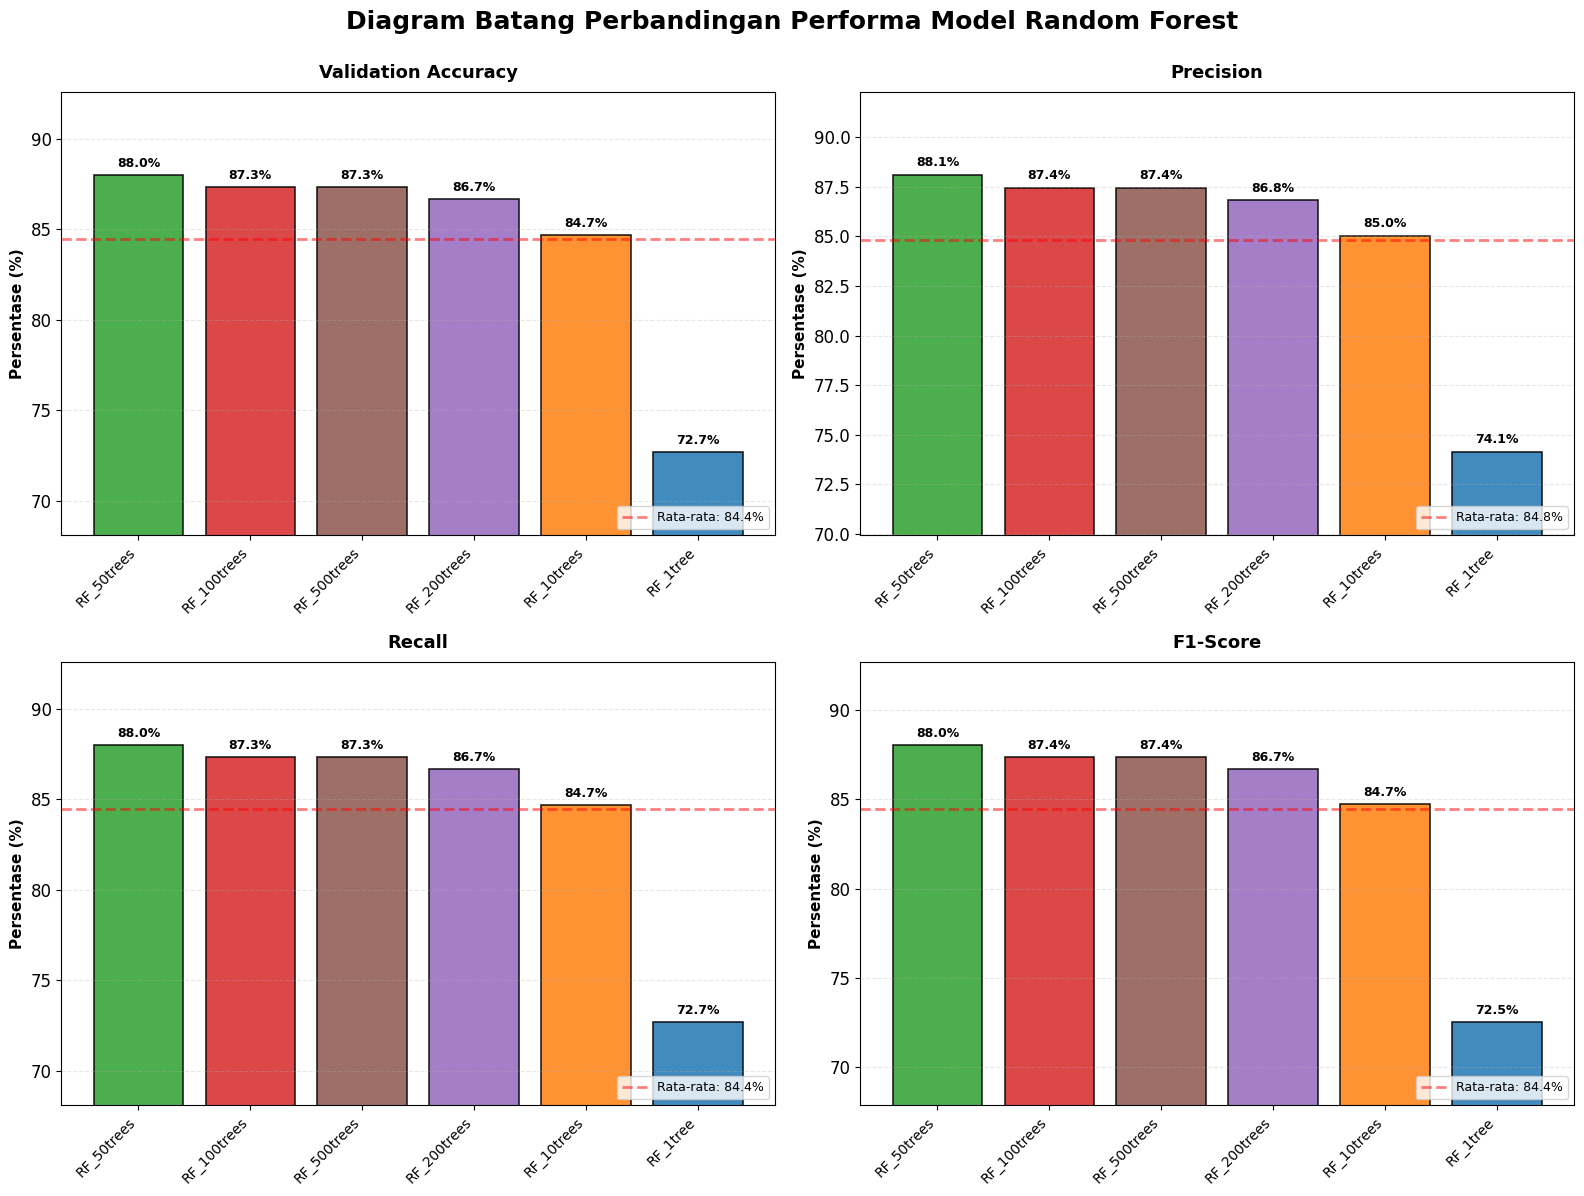

[2025-10-01 14:54:06] 📈 Membuat Diagram Batang Performa SVM...
[2025-10-01 14:54:06] Membuat plot performa per metrik...


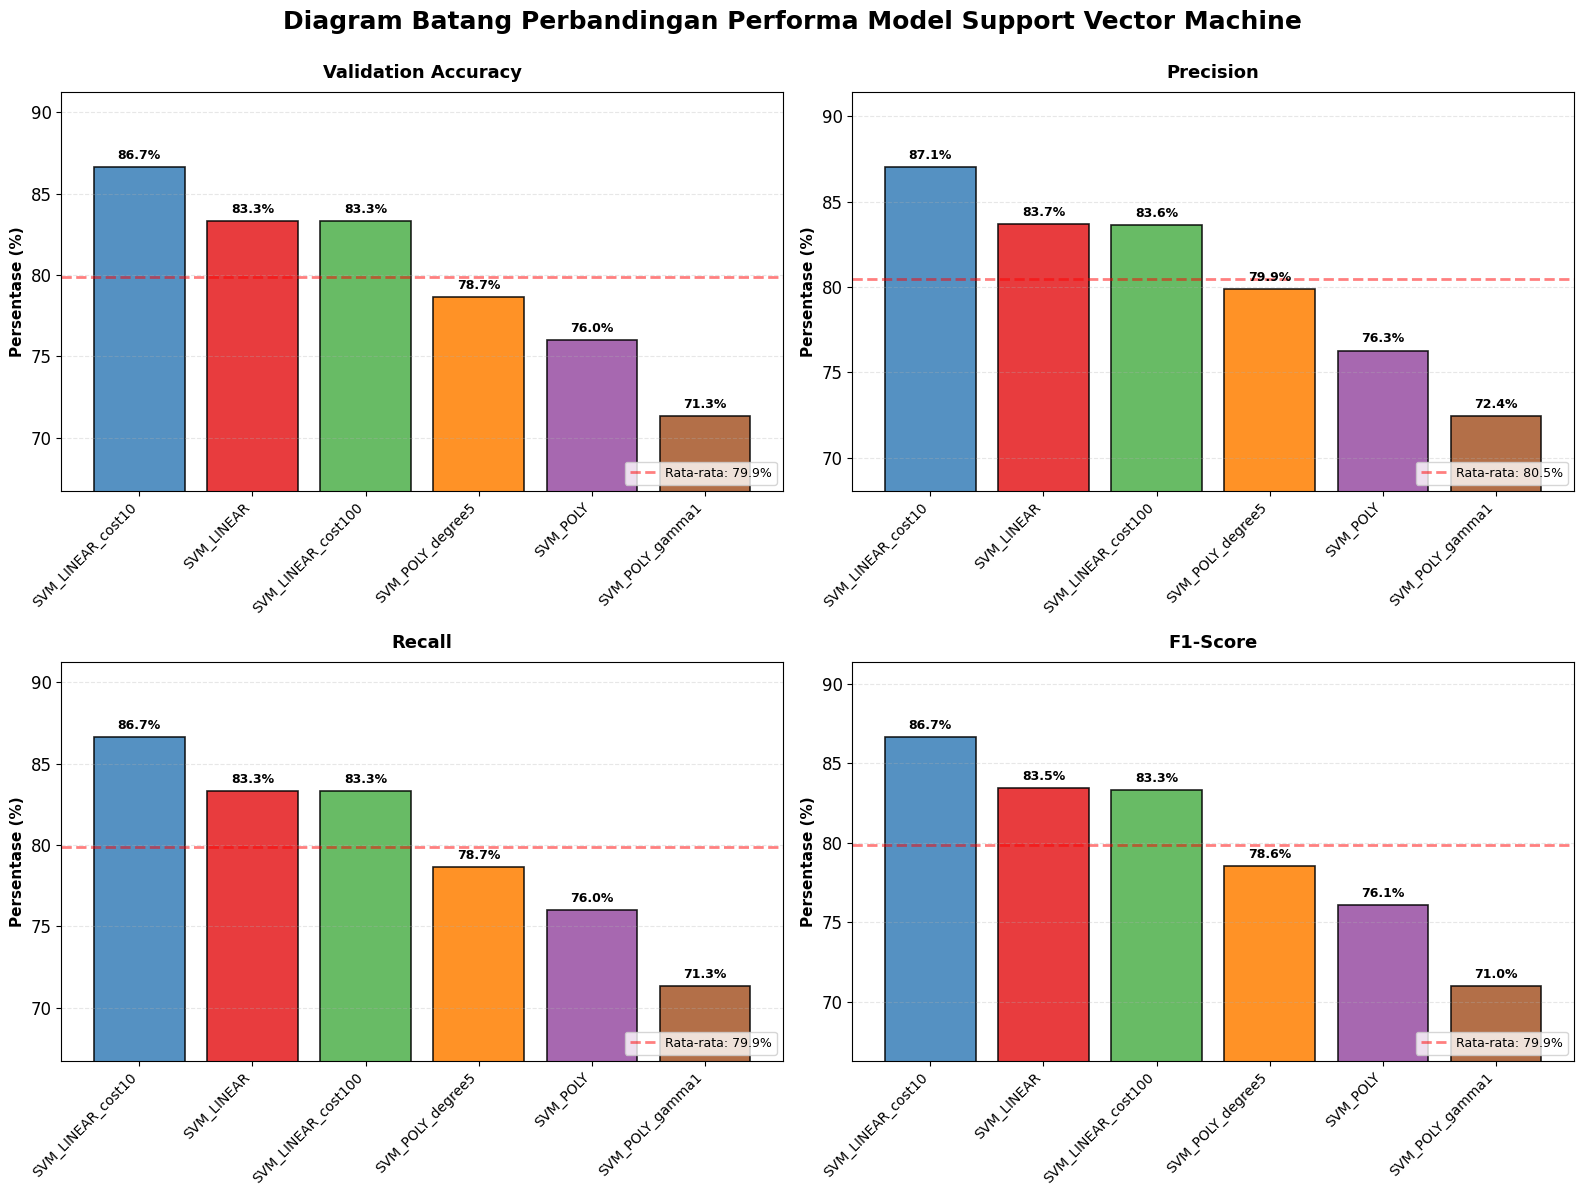

[2025-10-01 14:54:07] 📈 Menampilkan Confusion Matrix tiap Skenario...


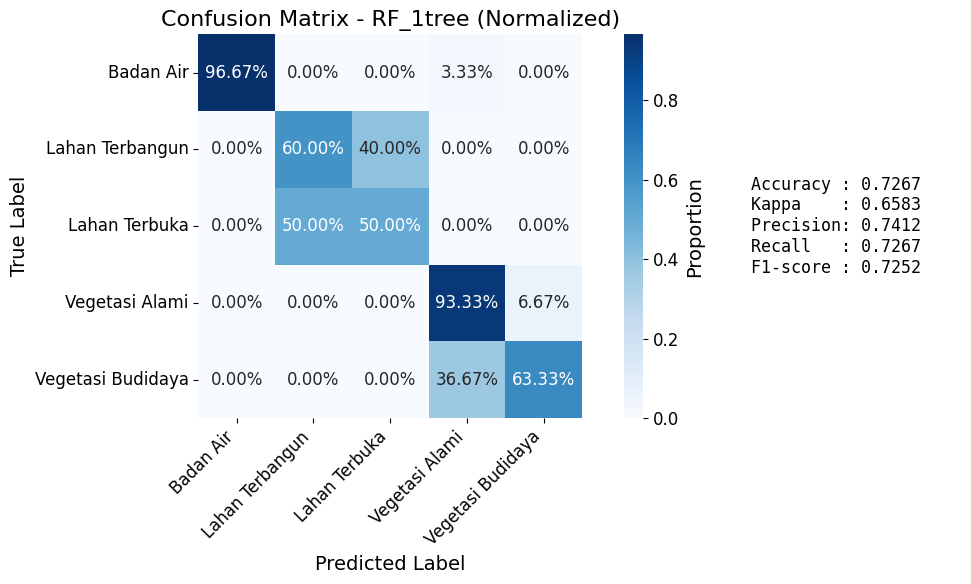

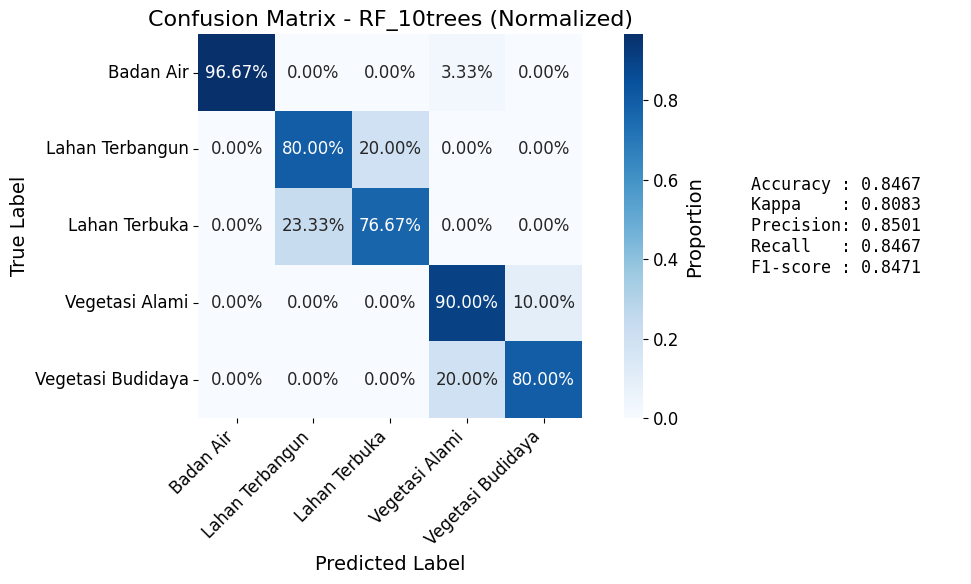

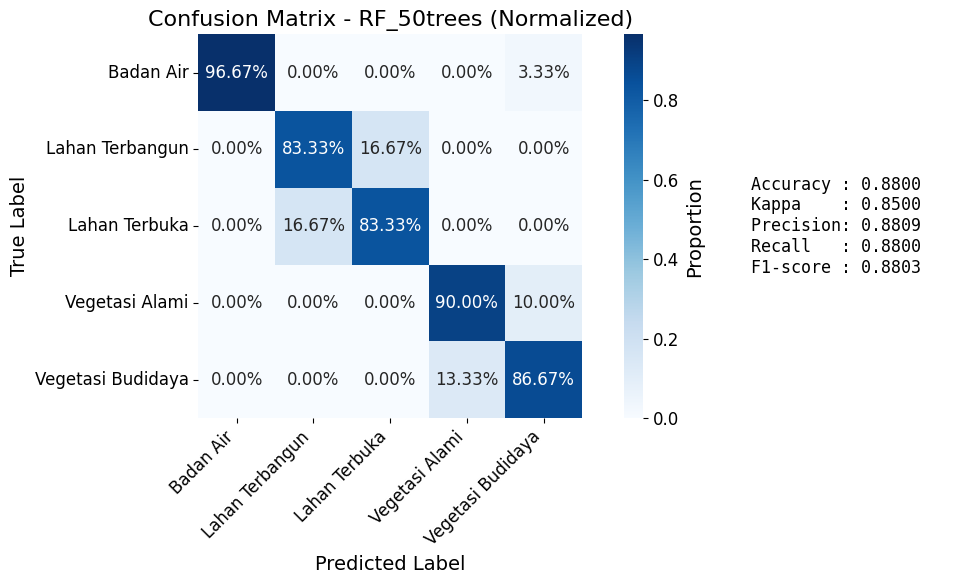

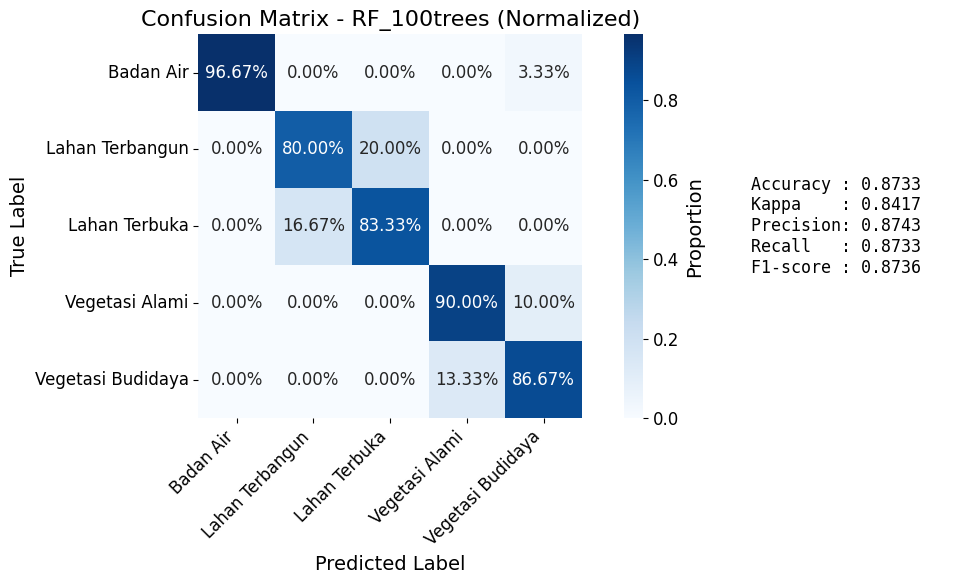

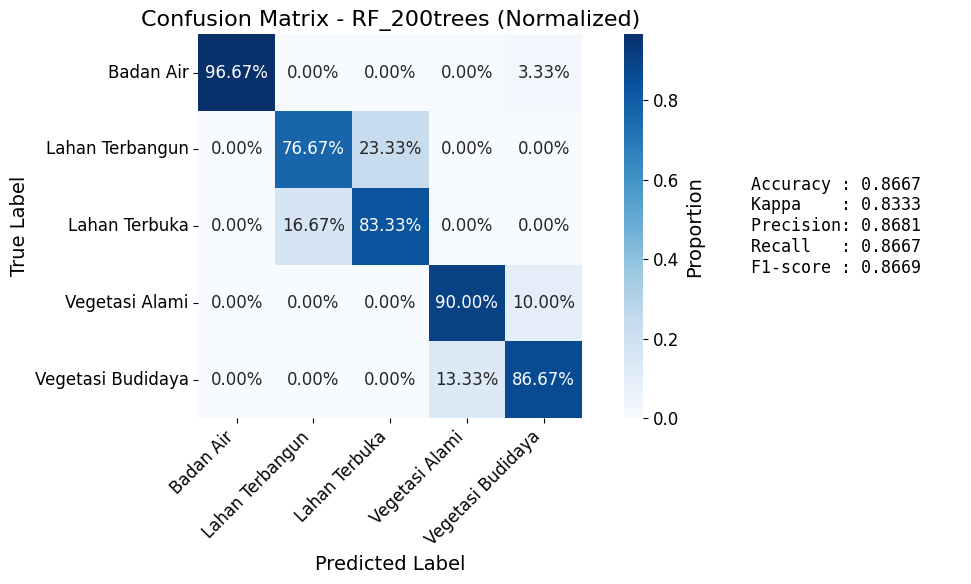

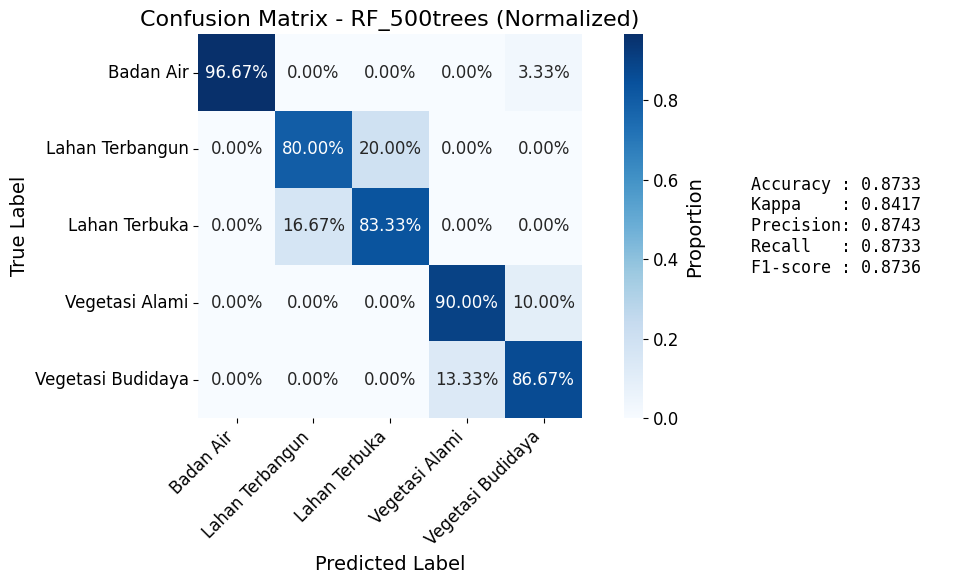

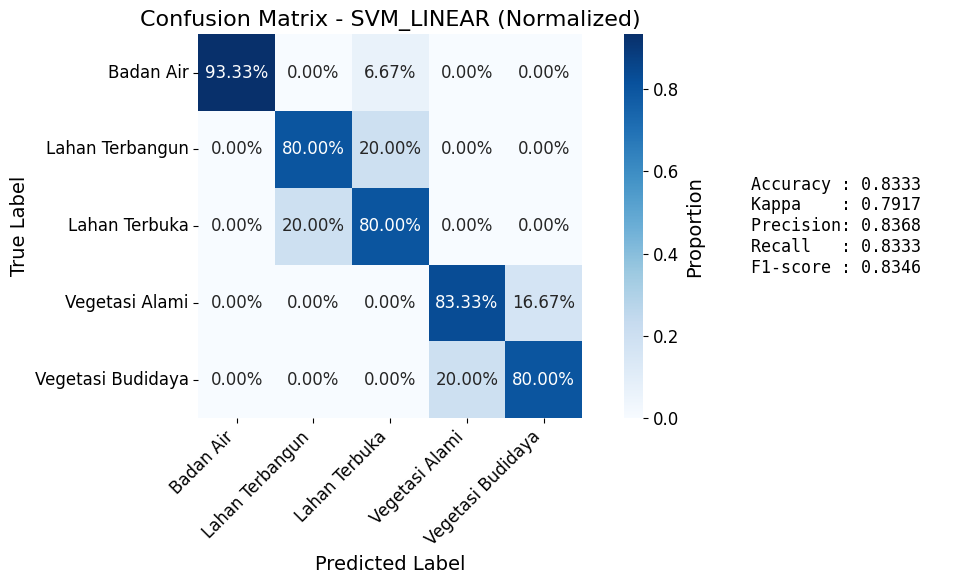

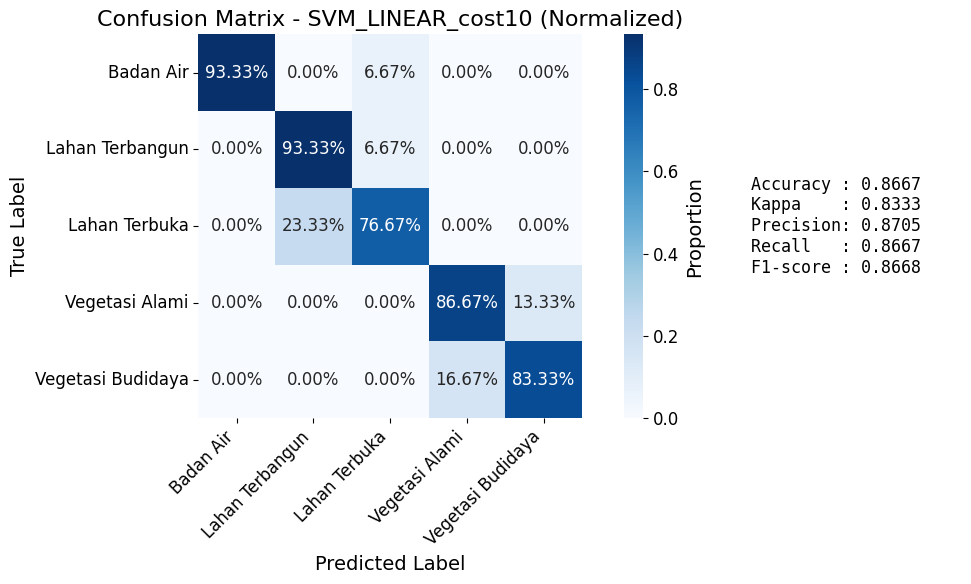

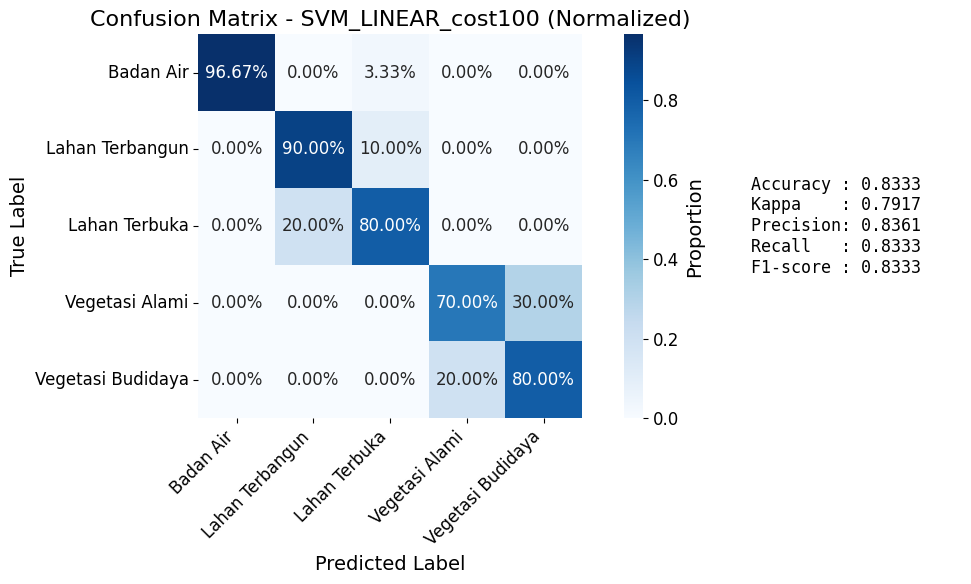

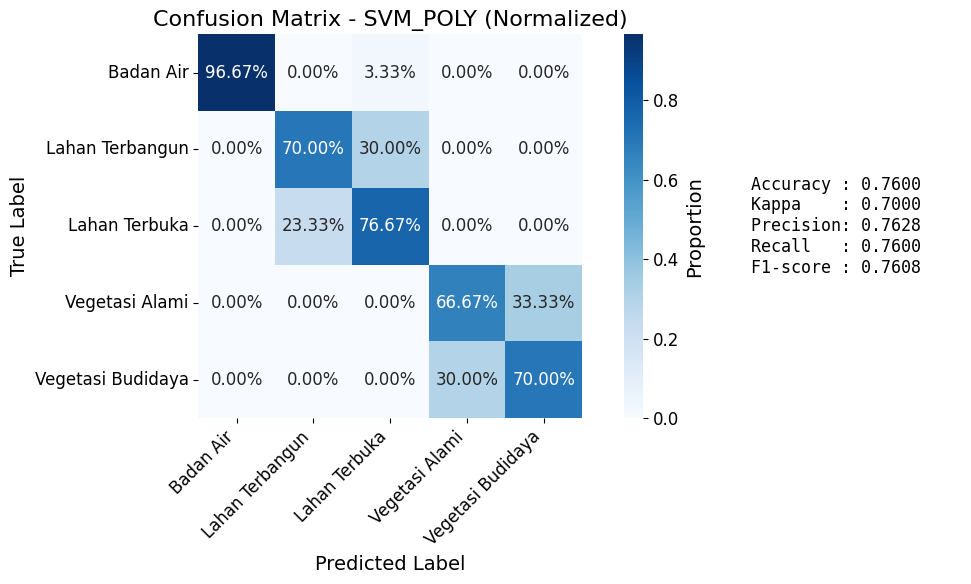

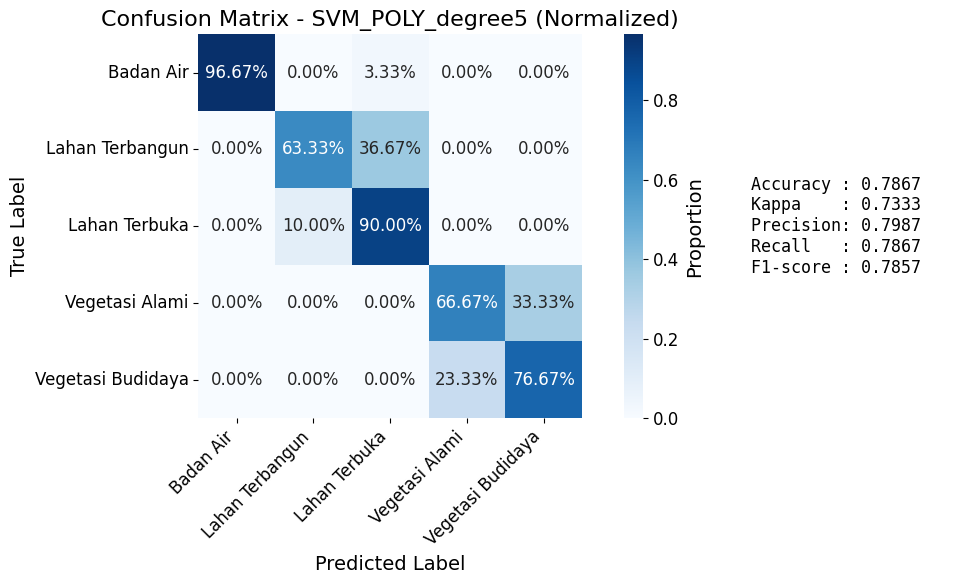

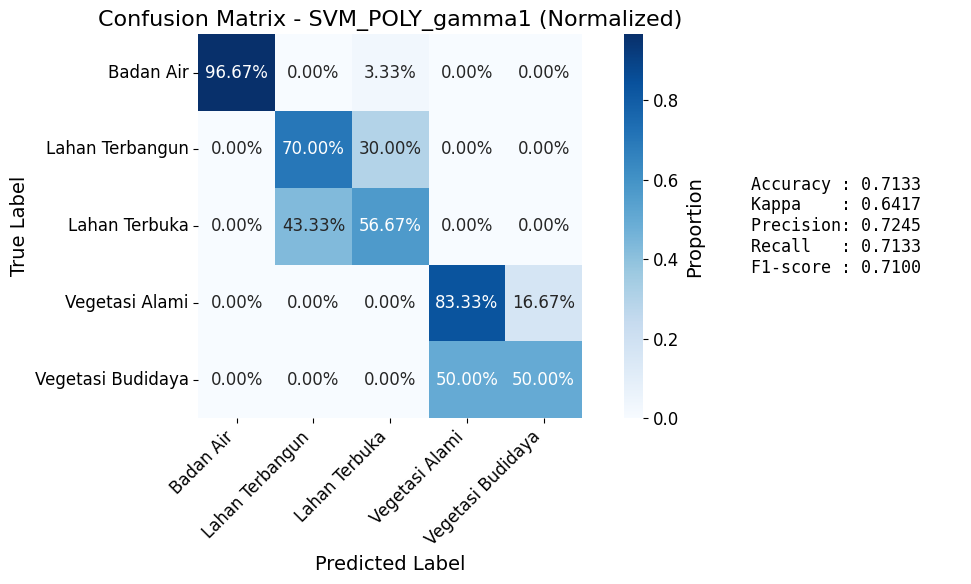

[2025-10-01 14:54:12] 🗺️ Menampilkan peta hasil klasifikasi...
[2025-10-01 14:54:12] Menginisialisasi peta
[2025-10-01 14:54:13] Peta diinisialisasi dengan area IKN
[2025-10-01 14:54:39] Memperbarui legenda dengan persentase luas
[2025-10-01 14:54:40] Menghitung luas untuk semua kelas tutupan lahan
[2025-10-01 14:54:46] Perhitungan luas selesai. Kelas yang ditemukan: [1, 2, 3, 4, 5]
[2025-10-01 14:54:46] Legenda diperbarui dengan persentase luas
[2025-10-01 14:54:46] Memperbarui legenda dengan persentase luas
[2025-10-01 14:54:47] Menghitung luas untuk semua kelas tutupan lahan
[2025-10-01 14:54:54] Perhitungan luas selesai. Kelas yang ditemukan: [1, 2, 3, 4, 5]
[2025-10-01 14:54:54] Legenda diperbarui dengan persentase luas
[2025-10-01 14:54:54] Memperbarui legenda dengan persentase luas
[2025-10-01 14:54:55] Menghitung luas untuk semua kelas tutupan lahan
[2025-10-01 14:55:04] Perhitungan luas selesai. Kelas yang ditemukan: [1, 2, 3, 4, 5]
[2025-10-01 14:55:04] Legenda diperbarui den

Map(center=[-0.8889816512180315, 116.74847420878828], controls=(WidgetControl(options=['position', 'transparen…

[2025-10-01 15:01:37] ✅ Semua visualisasi berhasil ditampilkan!


In [ ]:
# 3. VISUALISASI HASIL
# Menampilkan semua grafik performa dan peta hasil klasifikasi terbaik.
processor.visualize()

[2025-10-01 14:11:40] ================================================================================
[2025-10-01 14:11:40] ANALISIS CONFUSION MATRIX MODEL TERBAIK
[2025-10-01 14:11:40] ================================================================================
[2025-10-01 14:11:40] 
Confusion Matrix: RF_50trees


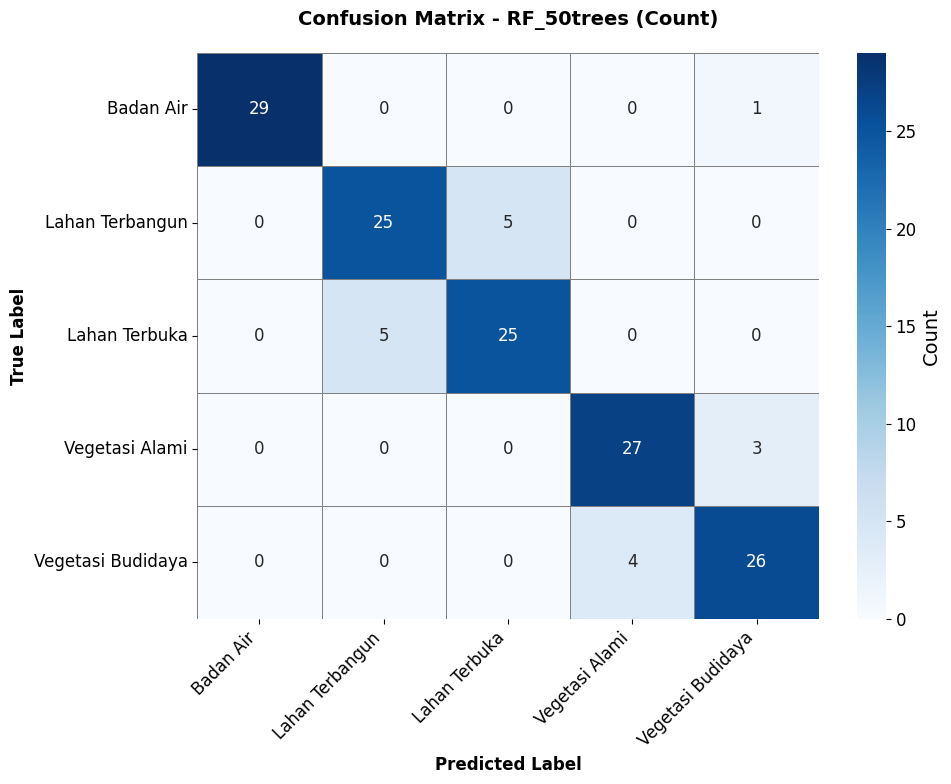

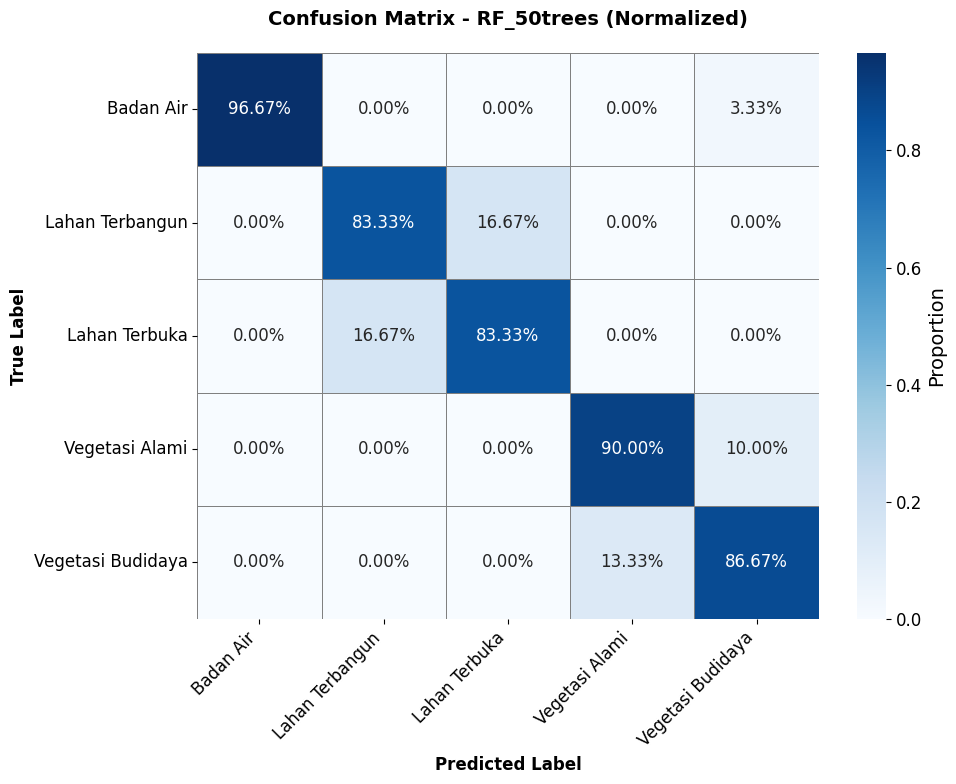

[2025-10-01 14:11:40] 
Confusion Matrix: SVM_LINEAR_cost10


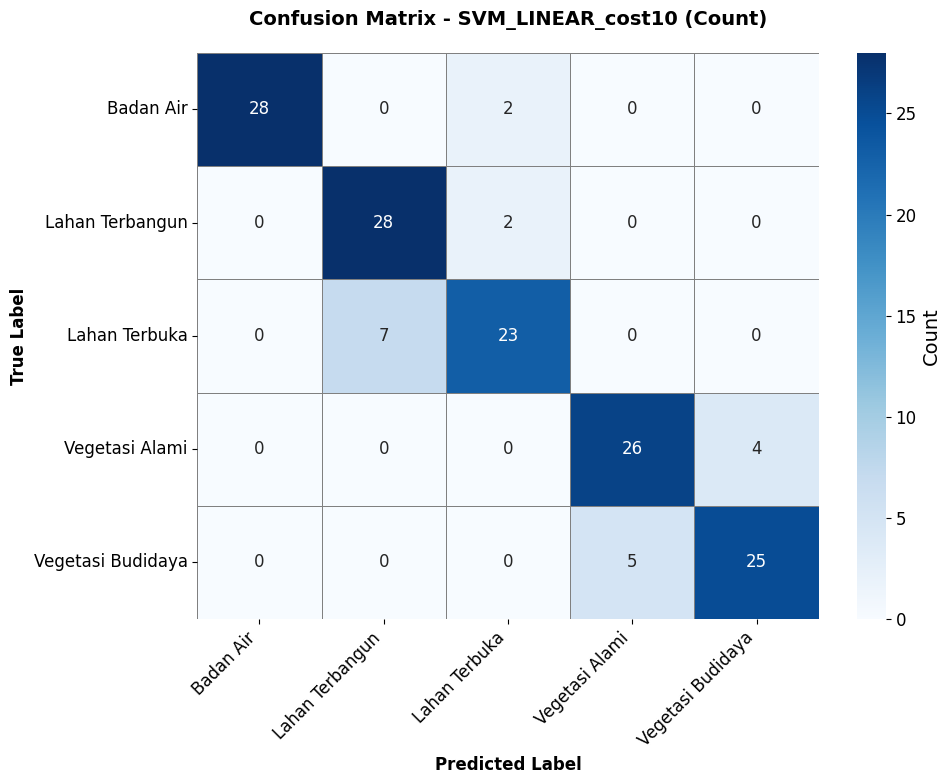

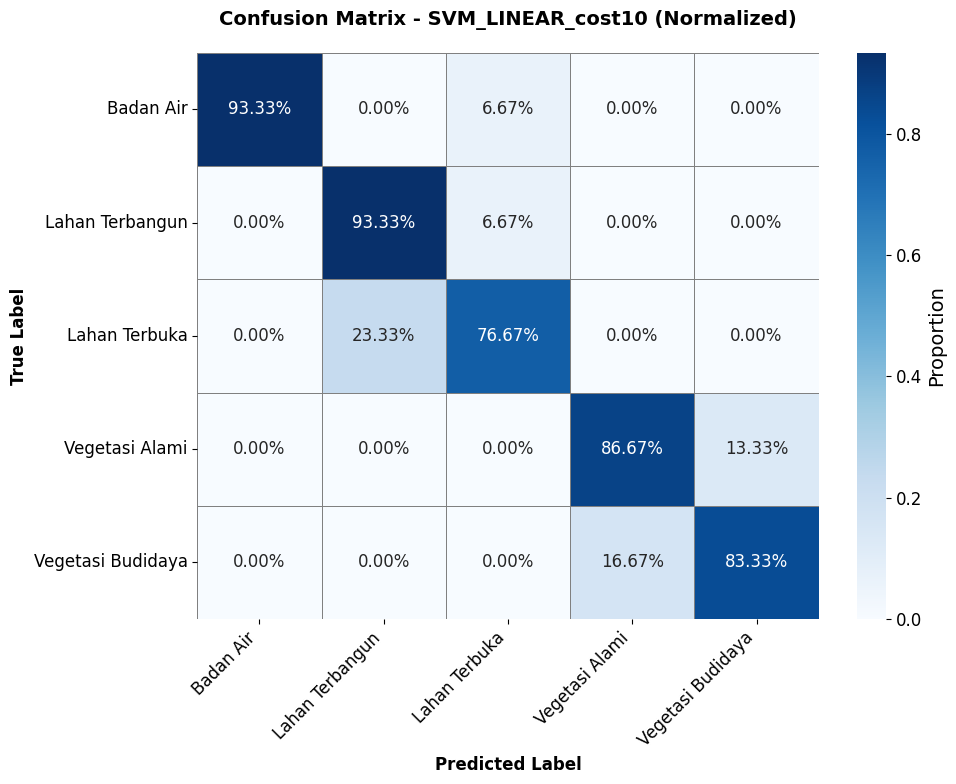

[2025-10-01 14:11:41] 
METRIK PER KELAS: RF_50trees


,Kelas,Producer's Accuracy (%),User's Accuracy (%),Commission Error (%),Omission Error (%),F1-Score (%),Jumlah Sampel
0,Badan Air,100.00,96.67,3.33,0.00,98.31,30
1,Lahan Terbangun,83.33,83.33,16.67,16.67,83.33,30
2,Lahan Terbuka,83.33,83.33,16.67,16.67,83.33,30
3,Vegetasi Alami,87.10,90.00,10.00,12.90,88.52,30
4,Vegetasi Budidaya,86.67,86.67,13.33,13.33,86.67,30


[2025-10-01 14:11:41] 
METRIK PER KELAS: SVM_LINEAR_cost10


,Kelas,Producer's Accuracy (%),User's Accuracy (%),Commission Error (%),Omission Error (%),F1-Score (%),Jumlah Sampel
0,Badan Air,100.00,93.33,6.67,0.00,96.55,30
1,Lahan Terbangun,80.00,93.33,6.67,20.00,86.15,30
2,Lahan Terbuka,85.19,76.67,23.33,14.81,80.70,30
3,Vegetasi Alami,83.87,86.67,13.33,16.13,85.25,30
4,Vegetasi Budidaya,86.21,83.33,16.67,13.79,84.75,30


[2025-10-01 14:11:41] 
ANALISIS KESALAHAN: RF_50trees


,True Class,Predicted As,Error Count,Error Rate (%)
1,Lahan Terbangun,Lahan Terbuka,5,16.666667
2,Lahan Terbuka,Lahan Terbangun,5,16.666667
4,Vegetasi Budidaya,Vegetasi Alami,4,13.333333
3,Vegetasi Alami,Vegetasi Budidaya,3,10.000000
0,Badan Air,Vegetasi Budidaya,1,3.333333


[2025-10-01 14:11:41] 
ANALISIS KESALAHAN: SVM_LINEAR_cost10


,True Class,Predicted As,Error Count,Error Rate (%)
2,Lahan Terbuka,Lahan Terbangun,7,23.333333
4,Vegetasi Budidaya,Vegetasi Alami,5,16.666667
3,Vegetasi Alami,Vegetasi Budidaya,4,13.333333
0,Badan Air,Lahan Terbuka,2,6.666667
1,Lahan Terbangun,Lahan Terbuka,2,6.666667


[2025-10-01 14:11:41] 
Perbandingan Metrik Per Kelas (RF vs SVM)


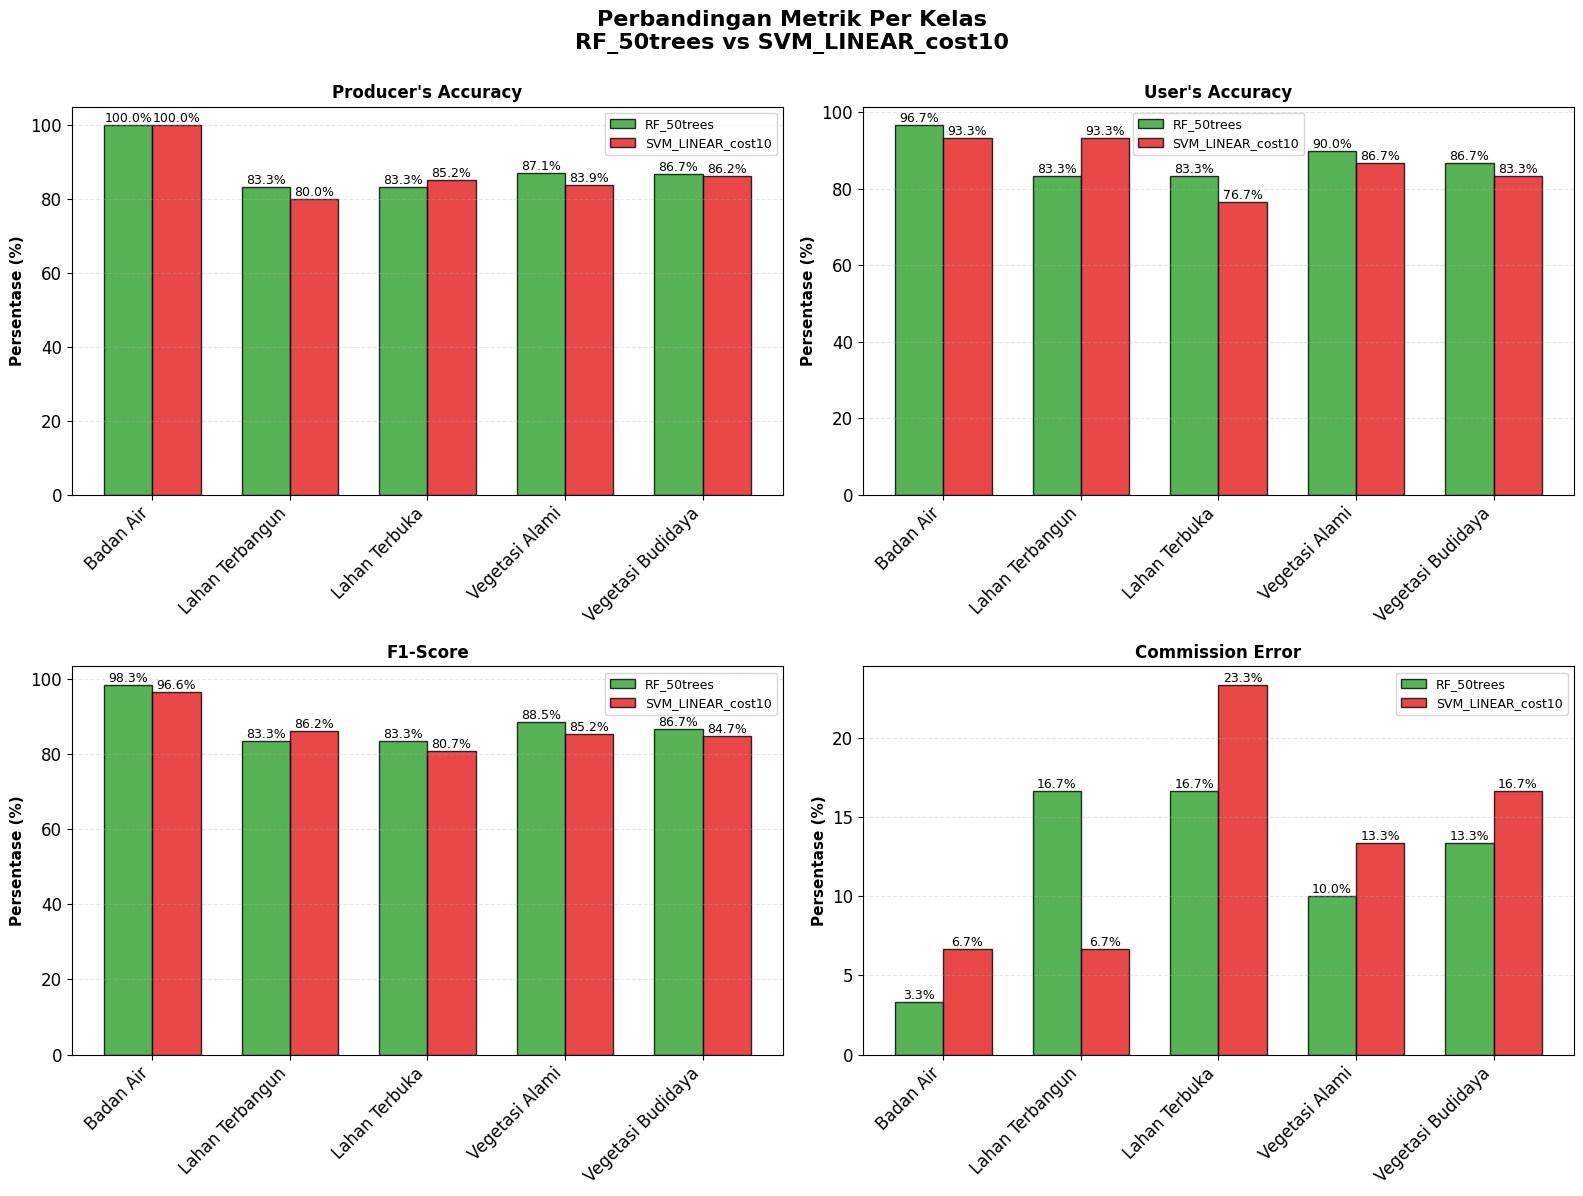

[2025-10-01 14:11:42] 
✅ Analisis confusion matrix selesai!


In [ ]:
# 4. ANALISIS CONFUSION MATRIX DETAIL
processor.analyze_best_models_confusion_matrix()

[2025-10-01 14:11:50] Menganalisis efisiensi komputasi model...
[2025-10-01 14:11:50] Membuat analisis waktu komputasi...


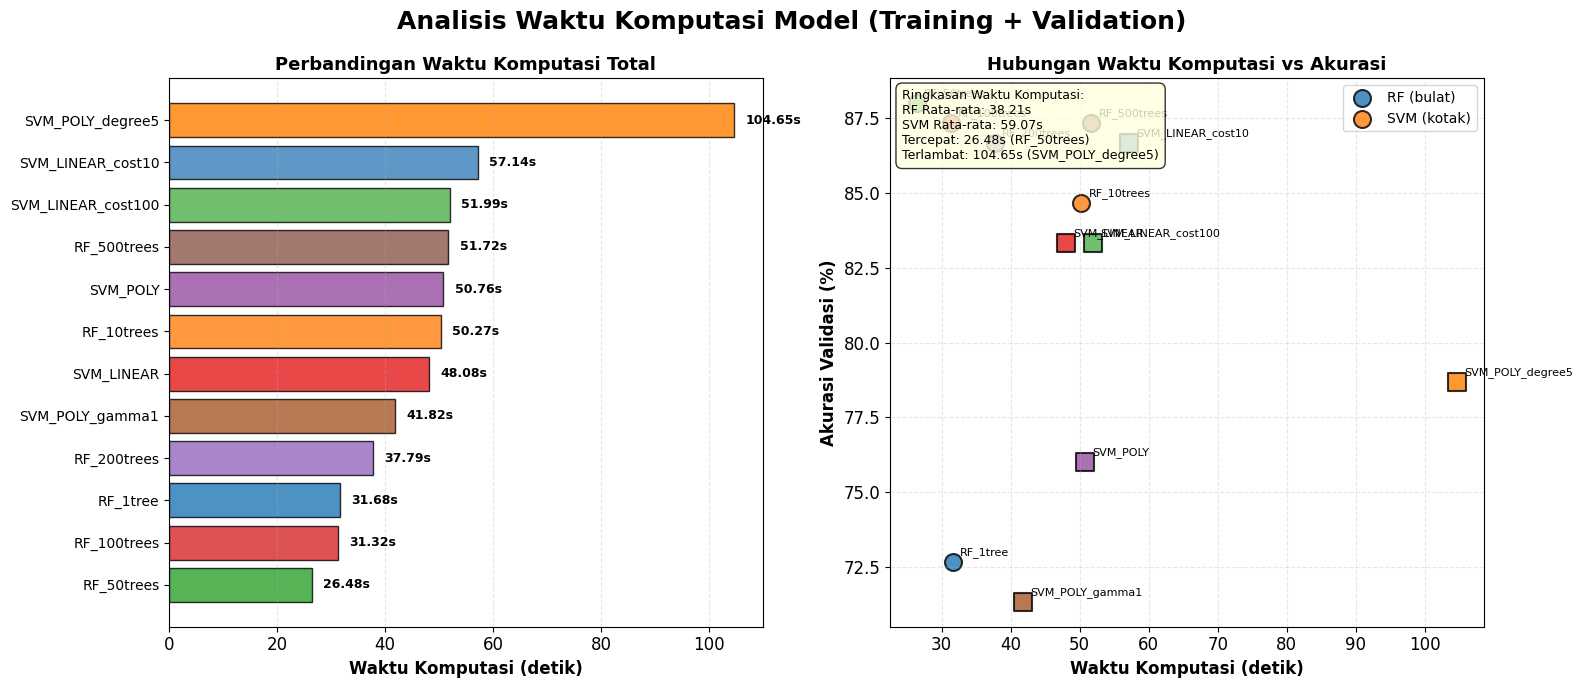


TABEL DETAIL WAKTU KOMPUTASI


,Model,Waktu Komputasi (s),Akurasi (%)
10,SVM_POLY_degree5,104.65,78.67
7,SVM_LINEAR_cost10,57.14,86.67
8,SVM_LINEAR_cost100,51.99,83.33
5,RF_500trees,51.72,87.33
9,SVM_POLY,50.76,76.00
1,RF_10trees,50.27,84.67
6,SVM_LINEAR,48.08,83.33
11,SVM_POLY_gamma1,41.82,71.33
4,RF_200trees,37.79,86.67
0,RF_1tree,31.68,72.67



RANKING EFISIENSI MODEL (Akurasi per Detik)


,Model,Akurasi (%),Waktu (s),Efisiensi Score
2,RF_50trees,88.0000,26.4849,0.0332
3,RF_100trees,87.3333,31.3214,0.0279
0,RF_1tree,72.6667,31.6799,0.0229
4,RF_200trees,86.6667,37.7936,0.0229
6,SVM_LINEAR,83.3333,48.0768,0.0173
11,SVM_POLY_gamma1,71.3333,41.8238,0.0171
5,RF_500trees,87.3333,51.7180,0.0169
1,RF_10trees,84.6667,50.2688,0.0168
8,SVM_LINEAR_cost100,83.3333,51.9859,0.0160
7,SVM_LINEAR_cost10,86.6667,57.1441,0.0152


[2025-10-01 14:11:51] Analisis efisiensi komputasi selesai!


In [ ]:
# 5. ANALISIS EFISIENSI WAKTU KOMPUTASI
processor.analyze_computational_efficiency()

In [ ]:
# 6. EKSPOR LAPORAN
processor.export_results(export_format=['csv'])

[2025-10-01 12:54:58] ✓ Hasil diekspor ke lulc_results_20251001_055457.csv


In [ ]:
# 7. EKSPOR CITRA SATELIT MENTAH (GEOTIFF) KE DRIVE
processor.export_satellite_images(enable_export=False)

[2025-10-01 12:55:31] Export citra satelit dilewatkan (enable_export=False). Gunakan opsi ini untuk kecepatan.


In [ ]:
# 8. EKSPOR PETA HASIL KLASIFIKASI (PNG) KE DRIVE
processor.export_png_maps()

[2025-10-01 12:57:10] ✅ RF_1tree disimpan ke /content/drive/MyDrive/LULC_PNG/RF_1tree.png
[2025-10-01 12:57:28] ✅ RF_10trees disimpan ke /content/drive/MyDrive/LULC_PNG/RF_10trees.png
[2025-10-01 12:57:59] ✅ RF_50trees disimpan ke /content/drive/MyDrive/LULC_PNG/RF_50trees.png
[2025-10-01 12:58:29] ✅ RF_100trees disimpan ke /content/drive/MyDrive/LULC_PNG/RF_100trees.png
[2025-10-01 12:59:01] ✅ RF_200trees disimpan ke /content/drive/MyDrive/LULC_PNG/RF_200trees.png
[2025-10-01 12:59:52] ✅ RF_500trees disimpan ke /content/drive/MyDrive/LULC_PNG/RF_500trees.png
[2025-10-01 13:00:23] ✅ SVM_LINEAR disimpan ke /content/drive/MyDrive/LULC_PNG/SVM_LINEAR.png
[2025-10-01 13:00:40] ✅ SVM_LINEAR_cost10 disimpan ke /content/drive/MyDrive/LULC_PNG/SVM_LINEAR_cost10.png
[2025-10-01 13:00:59] ✅ SVM_LINEAR_cost100 disimpan ke /content/drive/MyDrive/LULC_PNG/SVM_LINEAR_cost100.png
[2025-10-01 13:01:32] ✅ SVM_POLY disimpan ke /content/drive/MyDrive/LULC_PNG/SVM_POLY.png
[2025-10-01 13:01:59] ✅ SVM_POLY